In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from scipy import signal
import os
from datetime import datetime, timedelta
import re
from io import StringIO
from datetime import time
import statsmodels.api as sm
import warnings
from IPython.display import clear_output

In [2]:
experiment_raw_df = {}

## Import Mistras (AE Sensor) Hits Dataframe

In [3]:
skip_mistras_import = False
Mistras_filepath = ""
while True:
    # # Specify the file path directly
    # filename = input("Please enter the name of your Mistras .txt file (Enter 'None' to skip Mistras import): ")
    # if filename.strip().lower() == 'none':
    #     skip_mistras_import = True
    #     break
    # folder = input("Please enter the full path (not including the filename) to your .txt file: ")

    # if folder:
    #     Mistras_filepath = folder + "\\" + filename
    # else: 
    #     Mistras_filepath = filename

    Mistras_filepath = input("Please enter the absolute filepath of your Mistras .txt file (Enter 'None' to skip Mistras import): ")
    Mistras_filepath = Mistras_filepath.strip('"')
    print(Mistras_filepath)

    print("\nMistras Data Filepath: ", repr(Mistras_filepath))

    if os.path.isfile(Mistras_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")

C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic119\PD-acoustic119_hits.TXT

Mistras Data Filepath:  'C:\\Users\\sapierso\\Box\\PD-Acoustic Project Data\\0_FormattedData\\PD-acoustic119\\PD-acoustic119_hits.TXT'


In [4]:
def get_mistras_metadata(filepath, df):
    metadata = {}
    
    # This regex pattern matches a time format and optionally captures microseconds if present
    time_pattern = re.compile(r'\b(\d{2}:\d{2}:\d{2})(?:\.(\d+))?\b')
    
    with open(filepath, 'r') as file:
        for line in file:
            match = re.search(time_pattern, line)
            if match:
                time_str = match.group(1)  # Time in HH:MM:SS
                microseconds_str = match.group(2) if match.group(2) else '000000'  # Microseconds part if present, else '0'
                break
        else:
            # Handle case where no time is found
            return None

    # Append microseconds to the time string and parse
    full_time_str = f"{time_str}.{microseconds_str}"
    time_obj = datetime.strptime(full_time_str, "%H:%M:%S.%f")

    metadata['start_time'] = time_obj
    metadata['duration'] = df['SSSSSSSS.mmmuuun'].iloc[-1]
    return metadata

def import_mistras_file_to_df(filepath):
    # Read the data using read_csv, assuming tab-separated values (TSV); adjust delimiter if needed
    df = pd.read_csv(filepath, delim_whitespace=True, header=4)
    # There is a bad import on the 'SIG STRNGTH col because it has a space in the name and the file is whitespace-delimted
    column_names_AE_Node = [
        'ID', 'SSSSSSSS.mmmuuun', 'CH', 'RISE', 'COUN', 'ENER', 
        'DURATION', 'AMP', 'A-FRQ', 'RMS', 'ASL', 'PCNTS', 'THR', 'R-FRQ', 
        'I-FRQ', 'SIG STRNGTH', 'ABS-ENERGY'
    ]
    column_names_EasyAE = [
        'ID', 'SSSSSSSS.mmmuuun', 'PARA1', 'CH', 
        'RISE', 'COUN', 'ENER', 
        'DURATION', 'A-FRQ', 'RMS', 'PCNTS', 'THR', 'R-FRQ', 
        'I-FRQ', 'SIG STRNGTH', 'ABS-ENERGY', 'FRQ-C', 'P-FRQ', 'AMP', 'ASL'
    ]
    column_names = column_names_EasyAE
    # Keep all columns except the last one
    df = df.iloc[:, :-1]
    df.columns = column_names
    # Remove rows where any value is not a float
    # Attempt to convert all values to float
    df = df.apply(pd.to_numeric, errors='coerce')

    # Drop rows with any NaNs (i.e., conversion failures)
    df = df.dropna(how='any')

    return df

def process_mistras_df(df, metadata):
    # Drop 'ID' col
    df = df.drop('ID', axis=1)
    # Rename time col
    df.rename(columns={'SSSSSSSS.mmmuuun': 'TIME'}, inplace=True)
    
    # Add 'Absolute time' column to the data
    mistras_start_time_obj = metadata['start_time']
    seconds = df['TIME']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = mistras_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)
    
    return df

if not skip_mistras_import:
    mistras_df = import_mistras_file_to_df(Mistras_filepath)
    mistras_metadata = get_mistras_metadata(Mistras_filepath, mistras_df)
    mistras_df = process_mistras_df(mistras_df, mistras_metadata)
    print("Start time:", mistras_metadata['start_time'])
    print("Duration: " + str(mistras_metadata['duration']) + " s")

    experiment_raw_df['mistras_df'] = {'metadata': mistras_metadata, 'df': mistras_df}

    display(mistras_df)

    amp_type_counts = mistras_df['AMP'].apply(lambda x: type(x).__name__).value_counts()
    print("Type counts in 'AMP' column:")
    print(amp_type_counts)


Start time: 1900-01-01 11:55:49
Duration: 254.7346095 s


C:\Users\sapierso\AppData\Local\Temp\ipykernel_26608\4176063190.py:28: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, delim_whitespace=True, header=4)


,Absolute Time,TIME,PARA1,CH,RISE,COUN,ENER,DURATION,A-FRQ,RMS,PCNTS,THR,R-FRQ,I-FRQ,SIG STRNGTH,ABS-ENERGY,FRQ-C,P-FRQ,AMP,ASL
0,1900-01-01 11:56:26.722068500,37.722068,0.0180,1,1,1,0,1,1000,0.0,1,31,0,1000,3480.00,0.000000,112,18,31.0,18.8
1,1900-01-01 11:56:26.780228500,37.780228,0.0180,1,5,1,0,7,143,0.0,1,31,0,200,201.30,0.722456,109,3,31.0,18.8
2,1900-01-01 11:56:27.013531500,38.013531,0.0180,1,1,1,0,1,1000,0.0,1,31,0,1000,0.00,0.000000,103,18,31.0,19.0
3,1900-01-01 11:56:27.021916500,38.021917,0.0180,1,1,1,0,1,1000,0.0,1,31,0,1000,0.00,0.000000,104,18,31.0,19.1
4,1900-01-01 11:56:27.130148500,38.130148,0.0182,1,1,1,0,1,1000,0.0,1,31,0,1000,0.00,0.000000,97,18,31.0,19.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15774,1900-01-01 12:00:03.704696500,254.704697,0.0180,1,1,1,0,1,1000,0.0,1,31,0,1000,1525.00,0.000000,97,3,31.0,18.9
15775,1900-01-01 12:00:03.709508500,254.709508,0.0180,1,5,1,0,5,200,0.0,1,31,0,200,137.25,0.519498,110,3,31.2,18.9
15776,1900-01-01 12:00:03.711078500,254.711079,0.0182,1,151,1,0,151,7,0.0,1,31,0,6,2077.00,4.860000,100,2,31.0,19.2
15777,1900-01-01 12:00:03.711729500,254.711729,0.0180,1,195,1,0,205,5,0.0,1,31,0,5,4389.00,12.809000,104,2,31.8,19.2


Type counts in 'AMP' column:
AMP
float    15779
Name: count, dtype: int64


## Import Mistras (AE Sensor) Time-Driven Data Dataframe

In [5]:
skip_mistras_tdd_import = False
Mistras_tdd_filepath = ""
while True:
    # # Specify the file path directly
    # filename = input("Please enter the name of your Mistras TDD .txt file (Enter 'None' to skip import): ")
    # if filename.strip().lower() == 'none':
    #     skip_mistras_tdd_import = True
    #     break
    # folder = input("Please enter the full path (not including the filename) to your .txt file: ")

    # if folder:
    #     Mistras_tdd_filepath = folder + "\\" + filename
    # else: 
    #     Mistras_tdd_filepath = filename

    Mistras_tdd_filepath = input("Please enter the absolute filepath of your Mistras TDD .txt file (Enter 'None' to skip import): ")
    Mistras_tdd_filepath = Mistras_tdd_filepath.strip('"')
    print("\nMistras TDD Data Filepath: ", repr(Mistras_tdd_filepath))

    if os.path.isfile(Mistras_tdd_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")


Mistras TDD Data Filepath:  'C:\\Users\\sapierso\\Box\\PD-Acoustic Project Data\\0_FormattedData\\PD-acoustic119\\PD-acoustic119_time.txt'


In [6]:
def parse_tdd_data(file_path):
    # Initialize lists to store data
    timestamps = []
    rms = []
    asl = []
    thr = []
    abs_energy = []
    
    # Open and read the file
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('  2 '):
                # Extract timestamp
                timestamp = float(line.split()[1])
                timestamps.append(timestamp)
                
                # Read the next two lines
                _ = next(file)  # Skip the "CH:[    RMS ASL THR  ABS-ENERGY]" line
                channel_data = next(file).strip()
                
                # Extract channel data
                data = channel_data.split('[')[-1].split(']')[0].split()
                rms.append(float(data[0]))
                asl.append(float(data[3]))
                thr.append(float(data[1]))
                abs_energy.append(float(data[2]))
    
    # Create DataFrame
    df = pd.DataFrame({
        'SSSSSSSS.mmmuuun': timestamps,
        'RMS_CONTINUOUS': rms,
        'THR_CONTINUOUS': thr,
        'ABS_ENERGY_CONTINUOUS': abs_energy,
        'ASL_CONTINUOUS': asl,
    })
    
    return df

def process_mistras_tdd_df(df, metadata):
    # Rename time col
    df.rename(columns={'SSSSSSSS.mmmuuun': 'TIME'}, inplace=True)
    
    # Add 'Absolute time' column to the data
    mistras_start_time_obj = metadata['start_time']
    seconds = df['TIME']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = mistras_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)
    
    return df

mistras_tdd_df = None
if not skip_mistras_tdd_import:
    mistras_tdd_df = parse_tdd_data(Mistras_tdd_filepath)
    mistras_tdd_metadata = get_mistras_metadata(Mistras_tdd_filepath, mistras_tdd_df)
    mistras_tdd_df = process_mistras_tdd_df(mistras_tdd_df, mistras_tdd_metadata)
    print("Start time:", mistras_tdd_metadata['start_time'])
    print("Duration: " + str(mistras_tdd_metadata['duration']) + " s")
    experiment_raw_df['mistras_tdd_df'] = {'metadata': mistras_tdd_metadata, 'df': mistras_tdd_df}
    display(mistras_tdd_df)

Start time: 1900-01-01 11:55:49
Duration: 261.230039 s


,Absolute Time,TIME,RMS_CONTINUOUS,THR_CONTINUOUS,ABS_ENERGY_CONTINUOUS,ASL_CONTINUOUS
0,1900-01-01 11:55:49.010039,0.010039,0.0,31.0,0.000,0.1
1,1900-01-01 11:55:49.020039,0.020039,0.0,31.0,33.588,15.2
2,1900-01-01 11:55:49.030039,0.030039,0.0,31.0,33.333,16.5
3,1900-01-01 11:55:49.040039,0.040039,0.0,31.0,29.846,16.8
4,1900-01-01 11:55:49.050039,0.050039,0.0,31.0,32.634,17.1
...,...,...,...,...,...,...
26118,1900-01-01 12:00:10.190039,261.190039,0.0,31.0,29.854,18.1
26119,1900-01-01 12:00:10.200039,261.200039,0.0,31.0,28.228,18.1
26120,1900-01-01 12:00:10.210039,261.210039,0.0,31.0,29.187,18.1
26121,1900-01-01 12:00:10.220039,261.220039,0.0,31.0,31.367,18.1


## Import MPD CSV


In [7]:
skip_MPD_import = False
MPD_filepath = ""
while True:
    # # Specify the filepath directly
    # filename = input("Please enter the name of your MPD .csv file (Enter 'None' to skip import): ")
    # if filename.strip().lower() == 'none':
    #     skip_MPD_import = True
    #     break
    # folder = input("Please enter the full path (not including the filename) to your MPD .csv file: ")

    # if folder:
    #     MPD_filepath = folder + "\\" + filename
    # else: 
    #     MPD_filepath = filename

    MPD_filepath = input("Please enter the absolute filepath of your MPD .csv file (Enter 'None' to skip import): ")
    MPD_filepath = MPD_filepath.strip('"')
    print("\nMPD csv Filepath: ", repr(MPD_filepath))

    if os.path.isfile(MPD_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")

def extract_time_from_MPD_filename(filename):
    basename = os.path.basename(filename)
    pattern = r'(\d{2})h(\d{2})m(\d{2})s\.csv$'
    match = re.search(pattern, basename)
    if match:
        hours, minutes, seconds = match.groups()
        return int(hours), int(minutes), int(seconds)
    else:
        raise ValueError("Filename does not match the expected pattern 'HHhMMmSSs.csv'.")
    
def get_time_object(hours, minutes, seconds):
    return datetime(1900, 1, 1, hour=hours, minute=minutes, second=seconds)
    
def get_MPD_csv_metadata(filename, df):
    metadata = {}
    hours, minutes, seconds = extract_time_from_MPD_filename(filename)
    metadata['start_time'] = get_time_object(hours, minutes, seconds)
    metadata['duration'] = df["Time [s]"].iloc[-1]
    return metadata

def parse_MPD_csv_content(filepath):
    df = pd.read_csv(filepath, delimiter=';', skiprows=1)
    return df

def process_MPD_df(df, metadata):
    # Add 'Absolute time' column to the data
    mistras_start_time_obj = metadata['start_time']
    seconds = df['Time [s]']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = mistras_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)
    df.rename(columns={'IEC 60270 Apparent Charge (Q_IEC/WTD) [C]': 'IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'}, inplace=True)
    df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'] *= 1e12
    return df

MPD_df = None
if not skip_MPD_import:
    MPD_df = parse_MPD_csv_content(MPD_filepath)
    MPD_metadata = get_MPD_csv_metadata(MPD_filepath, MPD_df)
    MPD_df = process_MPD_df(MPD_df, MPD_metadata)
    print("Start time:", MPD_metadata['start_time'])
    print("Duration: " + str(MPD_metadata['duration']) + " s")
    experiment_raw_df['MPD_df'] = {'metadata': MPD_metadata, 'df': MPD_df}
    display(MPD_df)


MPD csv Filepath:  'C:\\Users\\sapierso\\Box\\PD-Acoustic Project Data\\0_FormattedData\\PD-acoustic119\\PD-acoustic119-2025-05-27_11h55m56s.csv'
Start time: 1900-01-01 11:55:56
Duration: 234.6 s


,Absolute Time,Time [s],IEC 60270 Apparent Charge (Q_IEC/WTD) [pC],AC Input RMS Voltage [V],AC Input Peak Voltage / Sqrt(2) [V],AC Input signal frequency [Hz],total PD Rate [Pulses/s],PD Rate relevant for Q_IEC/WTD [Pulses/s],Maximum Charge of PD events in interval [C],Quadratic Rate D (from IEC 60270) [C²/s],Average charge in interval [C],Average Q_IEC/WTD charge in interval [C],Minimum Charge of PD events in interval [C],Average discharge power in interval [W],Average discharge current in interval [A],AC Input Peak Current / Sqrt(2) [A],AC Input RMS Current [A]
0,1900-01-01 11:55:56.300,0.3,4.145134,91.490755,90.895152,59.989721,204141.957022,19.433262,3.982106e-10,3.356425e-19,9.512897e-13,8.398973e-12,1.000811e-13,-7.533420e-09,1.945957e-07,3.995341e-05,3.523380e-05
1,1900-01-01 11:55:56.600,0.6,4.078305,91.550030,90.987611,59.989779,204623.393103,29.368328,3.982106e-10,3.094725e-19,9.557265e-13,8.428759e-12,1.000811e-13,-2.908008e-09,1.788654e-07,3.995162e-05,3.526112e-05
2,1900-01-01 11:55:56.900,0.9,4.112701,91.491006,90.870654,59.989931,205515.901135,29.162127,3.982106e-10,3.239487e-19,9.602589e-13,8.456806e-12,1.000811e-13,-7.726341e-09,1.867399e-07,3.996732e-05,3.523061e-05
3,1900-01-01 11:55:57.200,1.2,4.060653,91.544218,91.001926,59.989652,205461.031522,28.074152,3.982106e-10,3.395421e-19,9.646022e-13,8.485867e-12,1.000811e-13,-1.104027e-08,1.952194e-07,3.987735e-05,3.524844e-05
4,1900-01-01 11:55:57.500,1.5,4.079438,91.567083,91.018858,59.989803,204501.901958,29.995440,3.982106e-10,3.130989e-19,9.689226e-13,8.515165e-12,1.000811e-13,-6.834722e-09,1.794690e-07,3.988439e-05,3.524066e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,1900-01-01 11:59:49.400,233.4,79.455539,0.007305,0.008092,180.216057,160382.549263,78.122208,1.266390e-08,1.259439e-14,1.140444e-10,4.068526e-09,4.945678e-12,-1.522228e-02,1.498166e-05,3.727888e-08,1.908380e-08
778,1900-01-01 11:59:49.700,233.7,79.619866,0.017291,0.019906,29.410502,160402.113695,87.173729,1.266390e-08,1.044928e-14,1.072315e-10,3.874198e-09,4.945678e-12,-1.281230e-02,1.292056e-05,1.628002e-08,8.481127e-09
779,1900-01-01 11:59:50.000,234.0,79.472734,0.044602,0.058516,10.016096,160378.569316,83.157997,1.220110e-08,9.805671e-15,1.000496e-10,3.679455e-09,4.945678e-12,-1.213374e-02,1.266490e-05,1.971349e-08,9.926741e-09
780,1900-01-01 11:59:50.300,234.3,79.751067,0.044751,0.055511,9.644505,159936.701938,68.581604,1.220110e-08,9.039776e-15,9.259728e-11,3.476875e-09,4.945678e-12,-1.118367e-02,1.235962e-05,1.003993e-08,6.167369e-09


## Process/Merge Data

In [8]:
class ArgumentConflict(Exception):
    def __init__(self, message="The arguments in this function overdefine the method"):
        self.message = message
        super().__init__(self.message)

# Post-process the merged dataset to calculate the # of hits
def count_ae_hits(df, n_bins=None, time_delta=None):
    if n_bins is not None and time_delta is not None:
        raise ArgumentConflict
    elif time_delta is not None and n_bins is None:
        n_bins = math.floor(df['TIME'].max() / time_delta)
    elif n_bins is not None and time_delta is None:
        time_delta = df['TIME'].max() / n_bins
    n_hits = []
    for start_time in range(0, math.floor(df['TIME'].max())-1, time_delta):
        end_time = start_time + time_delta
        # Selecting the subsection
        subsection = df[(df['TIME'] >= start_time) & (df['TIME'] < end_time)]
        # Count non-NaN entries in the 'Data' column
        count_non_nan = subsection['RISE'].notna().sum()
        n_hits.append(count_non_nan)
        # print(f"Time from {start_time} to {end_time} seconds: {count_non_nan} non-NaN values")
    hits = np.array(n_hits).astype(float)
    increments = np.arange(time_delta, time_delta * (n_bins), time_delta).astype(float)
    hits_df = pd.DataFrame({
        'TIME': increments,
        'Hits': hits
    })
    return hits_df

def adjust_MPD_relative_time(df, mistras_start_time, MPD_start_time):
    df['Time [s]'] = df['Time [s]'] - (mistras_start_time - MPD_start_time).total_seconds()
    return df

hits = count_ae_hits(mistras_df, time_delta=1)
mistras_df = pd.merge_asof(left=mistras_df, right=hits, on='TIME', direction='backward')
MPD_df = adjust_MPD_relative_time(MPD_df, mistras_metadata['start_time'], MPD_metadata['start_time'])

mistras_MPD_time_diff = (mistras_metadata['start_time'] - MPD_metadata['start_time']).total_seconds()
print("Time difference between Mistras and MPD:", mistras_MPD_time_diff)

Time difference between Mistras and MPD: -7.0


In [9]:
display(mistras_df)

,Absolute Time,TIME,PARA1,CH,RISE,COUN,ENER,DURATION,A-FRQ,RMS,...,THR,R-FRQ,I-FRQ,SIG STRNGTH,ABS-ENERGY,FRQ-C,P-FRQ,AMP,ASL,Hits
0,1900-01-01 11:56:26.722068500,37.722068,0.0180,1,1,1,0,1,1000,0.0,...,31,0,1000,3480.00,0.000000,112,18,31.0,18.8,0.0
1,1900-01-01 11:56:26.780228500,37.780228,0.0180,1,5,1,0,7,143,0.0,...,31,0,200,201.30,0.722456,109,3,31.0,18.8,0.0
2,1900-01-01 11:56:27.013531500,38.013531,0.0180,1,1,1,0,1,1000,0.0,...,31,0,1000,0.00,0.000000,103,18,31.0,19.0,2.0
3,1900-01-01 11:56:27.021916500,38.021917,0.0180,1,1,1,0,1,1000,0.0,...,31,0,1000,0.00,0.000000,104,18,31.0,19.1,2.0
4,1900-01-01 11:56:27.130148500,38.130148,0.0182,1,1,1,0,1,1000,0.0,...,31,0,1000,0.00,0.000000,97,18,31.0,19.2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15774,1900-01-01 12:00:03.704696500,254.704697,0.0180,1,1,1,0,1,1000,0.0,...,31,0,1000,1525.00,0.000000,97,3,31.0,18.9,0.0
15775,1900-01-01 12:00:03.709508500,254.709508,0.0180,1,5,1,0,5,200,0.0,...,31,0,200,137.25,0.519498,110,3,31.2,18.9,0.0
15776,1900-01-01 12:00:03.711078500,254.711079,0.0182,1,151,1,0,151,7,0.0,...,31,0,6,2077.00,4.860000,100,2,31.0,19.2,0.0
15777,1900-01-01 12:00:03.711729500,254.711729,0.0180,1,195,1,0,205,5,0.0,...,31,0,5,4389.00,12.809000,104,2,31.8,19.2,0.0


In [10]:
display(mistras_tdd_df)

,Absolute Time,TIME,RMS_CONTINUOUS,THR_CONTINUOUS,ABS_ENERGY_CONTINUOUS,ASL_CONTINUOUS
0,1900-01-01 11:55:49.010039,0.010039,0.0,31.0,0.000,0.1
1,1900-01-01 11:55:49.020039,0.020039,0.0,31.0,33.588,15.2
2,1900-01-01 11:55:49.030039,0.030039,0.0,31.0,33.333,16.5
3,1900-01-01 11:55:49.040039,0.040039,0.0,31.0,29.846,16.8
4,1900-01-01 11:55:49.050039,0.050039,0.0,31.0,32.634,17.1
...,...,...,...,...,...,...
26118,1900-01-01 12:00:10.190039,261.190039,0.0,31.0,29.854,18.1
26119,1900-01-01 12:00:10.200039,261.200039,0.0,31.0,28.228,18.1
26120,1900-01-01 12:00:10.210039,261.210039,0.0,31.0,29.187,18.1
26121,1900-01-01 12:00:10.220039,261.220039,0.0,31.0,31.367,18.1


In [11]:
display(MPD_df.head(15))

,Absolute Time,Time [s],IEC 60270 Apparent Charge (Q_IEC/WTD) [pC],AC Input RMS Voltage [V],AC Input Peak Voltage / Sqrt(2) [V],AC Input signal frequency [Hz],total PD Rate [Pulses/s],PD Rate relevant for Q_IEC/WTD [Pulses/s],Maximum Charge of PD events in interval [C],Quadratic Rate D (from IEC 60270) [C²/s],Average charge in interval [C],Average Q_IEC/WTD charge in interval [C],Minimum Charge of PD events in interval [C],Average discharge power in interval [W],Average discharge current in interval [A],AC Input Peak Current / Sqrt(2) [A],AC Input RMS Current [A]
0,1900-01-01 11:55:56.300,7.3,4.145134,91.490755,90.895152,59.989721,204141.957022,19.433262,3.982106e-10,3.356425e-19,9.512897e-13,8.398973e-12,1.000811e-13,-7.533420e-09,1.945957e-07,0.00004,0.000035
1,1900-01-01 11:55:56.600,7.6,4.078305,91.550030,90.987611,59.989779,204623.393103,29.368328,3.982106e-10,3.094725e-19,9.557265e-13,8.428759e-12,1.000811e-13,-2.908008e-09,1.788654e-07,0.00004,0.000035
2,1900-01-01 11:55:56.900,7.9,4.112701,91.491006,90.870654,59.989931,205515.901135,29.162127,3.982106e-10,3.239487e-19,9.602589e-13,8.456806e-12,1.000811e-13,-7.726341e-09,1.867399e-07,0.00004,0.000035
3,1900-01-01 11:55:57.200,8.2,4.060653,91.544218,91.001926,59.989652,205461.031522,28.074152,3.982106e-10,3.395421e-19,9.646022e-13,8.485867e-12,1.000811e-13,-1.104027e-08,1.952194e-07,0.00004,0.000035
4,1900-01-01 11:55:57.500,8.5,4.079438,91.567083,91.018858,59.989803,204501.901958,29.995440,3.982106e-10,3.130989e-19,9.689226e-13,8.515165e-12,1.000811e-13,-6.834722e-09,1.794690e-07,0.00004,0.000035
5,1900-01-01 11:55:57.800,8.8,4.274725,91.535028,91.010744,59.989898,205160.342029,7.498752,3.982106e-10,3.276060e-19,9.734287e-13,8.545196e-12,1.000811e-13,-4.165338e-09,1.873078e-07,0.00004,0.000035
6,1900-01-01 11:55:58.100,9.1,4.385025,91.552993,90.957810,59.990305,205197.589298,8.058466,3.982106e-10,3.432487e-19,9.776625e-13,8.581124e-12,1.000811e-13,-2.934846e-09,1.957561e-07,0.00004,0.000035
7,1900-01-01 11:55:58.400,9.4,3.897369,91.495566,90.921939,59.990292,204907.206552,52.020576,3.982106e-10,3.165469e-19,9.819271e-13,8.620031e-12,1.000811e-13,-4.207623e-09,1.800078e-07,0.00004,0.000035
8,1900-01-01 11:55:58.700,9.7,4.141877,91.473339,90.900785,59.990227,205616.071985,11.141034,3.982106e-10,3.311360e-19,9.863587e-13,8.644390e-12,1.000811e-13,-1.261242e-09,1.878400e-07,0.00004,0.000035
9,1900-01-01 11:55:59.000,10.0,4.021043,91.398171,90.785974,59.989682,205409.756733,25.941618,3.982106e-10,3.469083e-19,9.906419e-13,8.675972e-12,1.000811e-13,-1.266154e-09,1.963028e-07,0.00004,0.000035


## Get Voltage Type of Test

In [12]:
voltage_col_name = ""
while True:
    voltage_num = input("Please enter (1) for AC and (2) for DC: ")
    voltage_num = int(voltage_num.strip())
    if voltage_num == 1:
        voltage_col_name = 'AC Input RMS Voltage [V]'
    elif voltage_num == 2:
        voltage_col_name = 'DC component of Voltage at AC input [V]'
    else:
        print(f"Input '{voltage_num}' not recognized. Please try again.")
        continue

    print(f"Voltage type entered: {voltage_col_name}")
    break

Voltage type entered: AC Input RMS Voltage [V]


#### Plotting AE parameters

In [ ]:
AE_feature_names = [
    "RISE", 
    "COUN", 
    "ENER", 
    "DURATION", 
    "AMP", 
    "A-FRQ", 
    "RMS", 
    "ASL", 
    "PCNTS", 
    "R-FRQ", 
    "I-FRQ", 
    "SIG STRNGTH", 
    "ABS-ENERGY", 
    "FRQ-C", 
    "P-FRQ", 
    "Hits"
]
AE_features_to_plot = []
for AE_feature_name in AE_feature_names:
    if AE_feature_name in mistras_df.columns:
        AE_features_to_plot.append({"name": AE_feature_name, "plot_type": "scatter"})

"""Old plotting function without subplot bounding boxes"""

# def plot_AE_features(mistras_df, AE_features_to_plot, trigger_delay=1.0, time_range=None, MPD_time_adjust=0, two_phase_spans=None):
#     """
#     Plot AE features with optional time range filtering
    
#     Parameters:
#         mistras_df (pd.DataFrame): DataFrame containing the AE data
#         AE_features_to_plot (list): List of features to plot
#         trigger_delay (float): Trigger delay value
#         time_range (tuple): Optional (start_time, end_time) in seconds. If None, plots all data
#         two_phase_spans (list): Optional list of two-phase span tuples
#     """
#     num_subplots = len(AE_features_to_plot)
#     columns = 3
#     rows = math.ceil(num_subplots / columns)
#     mpl.rcParams['font.size'] = 8

#     # Filter data based on time_range if provided
#     plot_df = mistras_df
#     if time_range is not None:
#         start_time, end_time = time_range
#         plot_df = mistras_df[(mistras_df['TIME'] >= start_time) & 
#                             (mistras_df['TIME'] <= end_time)].copy()

#     # Create a figure with a specified size
#     fig = plt.figure(figsize=(18, rows * 4))
    
#     # Create a GridSpec with specified height and width ratios
#     gs = gridspec.GridSpec(rows, columns, height_ratios=[1]*rows, width_ratios=[1]*columns)

#     # Create subplots using the GridSpec
#     axs = []
#     for r in range(rows):
#         for c in range(columns):
#             if len(axs) < num_subplots:
#                 axs.append(fig.add_subplot(gs[r, c]))

#     for i, ax in enumerate(axs):
#         if i < num_subplots:        
#             # Plot the AE feature
#             feature_to_plot = AE_features_to_plot[i]['name']
#             plot_type = AE_features_to_plot[i]['plot_type']

#             if plot_type == 'scatter':
#                 AE_plot = ax.scatter(plot_df['TIME'], plot_df[feature_to_plot], 
#                                    color='indigo', label=feature_to_plot, s=1)
#             elif plot_type == 'line':
#                 AE_plot, = ax.plot(plot_df['TIME'], plot_df[feature_to_plot], 
#                                  color='indigo', label=feature_to_plot)
                
#             # Also plot Voltage and PD Apparent Charge
#             ax2 = ax.twinx()
#             ax3 = ax.twinx()
#             ax2.set_ylabel("AC Input RMS Voltage [V]")
#             ax3.set_ylabel("Apparent Charge [pC]")
#             ax3.spines['right'].set_position(('outward', 60))
#             MPD_voltage_plot, = ax2.plot(MPD_df['Time [s]'] + MPD_time_adjust, MPD_df['AC Input RMS Voltage [V]'], color='green', label='RMS Voltage')
#             MPD_PD_plot, = ax3.plot(MPD_df['Time [s]'] + MPD_time_adjust, MPD_df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'], color='blue', label='Apparent Charge')

#             if feature_to_plot == 'Hits':
#                 ax.set_ylim([0, 250])

#             ax.set_ylabel(feature_to_plot)
#             lines = [AE_plot, MPD_voltage_plot, MPD_PD_plot]
#             labels = [line.get_label() for line in lines]
#             ax.legend(lines, labels, loc='upper left')
            
#             # Set x-axis limits if time_range is provided
#             if time_range is not None:
#                 ax.set_xlim(time_range)
            
#             if two_phase_spans:
#                 for two_phase_span in two_phase_spans:
#                     ax.axvspan(two_phase_span[0]-trigger_delay, 
#                              two_phase_span[1]-trigger_delay, 
#                              color='red', alpha=0.2)
#         else:
#             # Hide unused subplots
#             ax.set_visible(False)

#     plt.tight_layout()
#     plt.show()

# # Plot all data (default behavior)
# plot_AE_features(
#     mistras_df, 
#     AE_features_to_plot, 
#     # time_range=(0, 40),
#     MPD_time_adjust = -2
# )

'Old plotting function without subplot bounding boxes'

## Define Plotting Functions

In [14]:
def plot_single_AE_feature(mistras_df, AE_feature, trigger_delay=1.0, time_range=None, MPD_time_adjust=0, 
                    vertical_line_time: float = None, time_error: float = None, two_phase_spans=None, width=8, height=5, title=None, ae_ymin=None, ae_ymax=None):
    """
    Plot a single AE feature with optional time range filtering and additional MPD plots.
    
    Parameters:
        mistras_df (pd.DataFrame): DataFrame containing the AE data.
        AE_feature (dict): Dictionary with keys 'name' and 'plot_type' for the feature to plot.
        trigger_delay (float): Trigger delay value.
        time_range (tuple): Optional (start_time, end_time) in seconds. If None, plots all data.
        MPD_time_adjust (float): Time adjustment for the MPD data.
        vertical_line_time (float): If provided, draws a red dashed vertical line at this time.
        two_phase_spans (list): Optional list of tuples, each specifying a span to highlight.
        width (int): Width of the figure.
        height (int): Height of the figure.
        title (str): Title to be displayed on the graph.
    """
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    mpl.rcParams['font.size'] = 12

    # Create figure and axis for single AE feature plot
    fig, ax = plt.subplots(figsize=(width, height))
    
    # Filter the data based on the time_range if provided
    plot_df = mistras_df
    if time_range is not None:
        start_time, end_time = time_range
        plot_df = mistras_df[(mistras_df['TIME'] >= start_time) & 
                             (mistras_df['TIME'] <= end_time)].copy()
    
    # Plot the AE feature based on the specified type (scatter or line)
    feature_name = AE_feature['name']
    plot_type = AE_feature['plot_type']
    
    if plot_type == 'scatter':
        AE_plot = ax.scatter(plot_df['TIME'], plot_df[feature_name],
                             color='indigo', label=feature_name, s=1)
    elif plot_type == 'line':
        AE_plot, = ax.plot(plot_df['TIME'], plot_df[feature_name],
                           color='indigo', label=feature_name)
    else:
        raise ValueError("Unsupported plot type. Use 'scatter' or 'line'.")
    
    # Create twin axes for MPD voltage and apparent charge
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    # ax2.set_ylabel("AC Input RMS Voltage [V]", fontsize=12)
    ax2.set_ylabel(voltage_col_name, fontsize=12)
    ax3.set_ylabel("Apparent Charge [pC]", fontsize=12)
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
    
    # Plot MPD data (assumes MPD_df is defined globally)
    # Shift MPD time and apply mask if time_range is provided
    MPD_time_shifted = MPD_df['Time [s]'] + MPD_time_adjust

    if time_range is not None:
        MPD_time_mask = (MPD_time_shifted >= start_time) & (MPD_time_shifted <= end_time)
        MPD_df_filtered = MPD_df[MPD_time_mask].copy()
        MPD_time_filtered = MPD_time_shifted[MPD_time_mask]
    else:
        MPD_df_filtered = MPD_df
        MPD_time_filtered = MPD_time_shifted

    # Plot MPD data
    MPD_voltage_plot, = ax2.plot(MPD_time_filtered, 
                                MPD_df_filtered[voltage_col_name],
                                color='green', label='RMS Voltage')

    MPD_PD_plot, = ax3.plot(MPD_time_filtered, 
                            MPD_df_filtered['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'], 
                            color='blue', label='Apparent Charge')

    
    ax.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)
    ax3.set_ylim(ymin=0)

    ax.set_ylim(ymin=ae_ymin, ymax=ae_ymax)
    
    # Apply additional configurations
    # if feature_name == 'Hits':
    #     ax.set_ylim([0, 250])  # REVISIT upper limit with new AE DAQ
    
    ax.set_xlabel("Time [s]", fontsize=12)
    ax.set_ylabel(feature_name, fontsize=12)
    
    # Set title if provided
    if title:
        ax.set_title(title, fontsize=14)
    
    # Create a combined legend for all plots
    lines = [AE_plot, MPD_voltage_plot, MPD_PD_plot]
    labels = [line.get_label() for line in lines]
    ax.legend(lines, labels, loc='upper left')
    
    # Set x-axis limits if a time_range is provided
    if time_range is not None:
        ax.set_xlim(time_range)
    
    # Draw vertical line if specified
    if vertical_line_time is not None:
        ax.axvline(x=vertical_line_time, color='red', linestyle='--')
        if time_error is not None:
            ax.axvspan(vertical_line_time-time_error, vertical_line_time+time_error, color='red', alpha=0.2)
    
    # Draw shaded spans for two-phase regions if provided
    if two_phase_spans:
        for span in two_phase_spans:
            ax.axvspan(span[0] - trigger_delay, span[1] - trigger_delay, color='red', alpha=0.2)
    
    plt.show()


def plot_AE_features(mistras_df, AE_features_to_plot, trigger_delay=1.0, time_range=None, MPD_time_adjust=0, vertical_line_time=None, two_phase_spans=None, 
                     width_per_subplot=8, height_per_subplot=5, title=None, columns=3):
    """
    Plot AE features with optional time range filtering and bordered axes groups
    
    Parameters:
        mistras_df (pd.DataFrame): DataFrame containing the AE data
        AE_features_to_plot (list): List of features to plot
        trigger_delay (float): Trigger delay value
        time_range (tuple): Optional (start_time, end_time) in seconds. If None, plots all data
        two_phase_spans (list): Optional list of two-phase span tuples
    """
    num_subplots = len(AE_features_to_plot)
    rows = math.ceil(num_subplots / columns)
    mpl.rcParams['font.size'] = 8

    # Create a figure with a specified size
    fig = plt.figure(figsize=(columns * width_per_subplot, rows * height_per_subplot))
    
    # Create a GridSpec with specified height and width ratios
    gs = gridspec.GridSpec(rows, columns, 
                          height_ratios=[1]*rows, 
                          width_ratios=[1]*columns)
    
    # Enable interactive mode for getting renderer
    plt.ion()
    
    # Filter data based on time_range if provided
    plot_df = mistras_df
    if time_range is not None:
        start_time, end_time = time_range
        plot_df = mistras_df[(mistras_df['TIME'] >= start_time) & 
                            (mistras_df['TIME'] <= end_time)].copy()

    # Create subplots using the GridSpec
    axs = []
    twin_axes = []  # Store pairs of twin axes
    for r in range(rows):
        for c in range(columns):
            if len(axs) < num_subplots:
                axs.append(fig.add_subplot(gs[r, c]))
                twin_axes.append([None, None])  # Initialize twin axes storage

    for i, ax in enumerate(axs):
        if i < num_subplots:        
            # Plot the AE feature
            ax.grid(False)
            feature_to_plot = AE_features_to_plot[i]['name']
            plot_type = AE_features_to_plot[i]['plot_type']
            if plot_type == 'scatter':
                AE_plot = ax.scatter(plot_df['TIME'], plot_df[feature_to_plot], 
                                color='indigo', label=feature_to_plot, s=1)
            elif plot_type == 'line':
                AE_plot, = ax.plot(plot_df['TIME'], plot_df[feature_to_plot], 
                                color='indigo', label=feature_to_plot)

            # Create and store twin axes
            ax2 = ax.twinx()
            ax3 = ax.twinx()
            twin_axes[i] = [ax2, ax3]  # Store references to twin axes
            
            ax2.set_ylabel(voltage_col_name)
            ax3.set_ylabel("Apparent Charge [pC]")
            ax3.spines['right'].set_position(('outward', 60))
            
            MPD_voltage_plot, = ax2.plot(MPD_df['Time [s]'] + MPD_time_adjust, 
                                       MPD_df[voltage_col_name], 
                                       color='green', label='RMS Voltage')
            MPD_PD_plot, = ax3.plot(MPD_df['Time [s]'] + MPD_time_adjust, 
                                   MPD_df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'], 
                                   color='blue', label='Apparent Charge')
            
            ax.set_ylim(ymin=0)
            ax2.set_ylim(ymin=0)
            ax3.set_ylim(ymin=0)

            if feature_to_plot == 'Hits':
                ax.set_ylim([0, 250])

            ax.set_xlabel("Time [s]")
            ax.set_ylabel(feature_to_plot)
            lines = [AE_plot, MPD_voltage_plot, MPD_PD_plot]
            labels = [line.get_label() for line in lines]
            ax.legend(lines, labels, loc='upper left')

            # Set x-axis limits if time_range is provided
            if time_range is not None:
                ax.set_xlim(time_range)

            # Draw red vertical line at the selected time if provided
            if vertical_line_time is not None:
                ax.axvline(x=vertical_line_time, color='red', linestyle='--')

            if two_phase_spans:
                for two_phase_span in two_phase_spans:
                    ax.axvspan(two_phase_span[0]-trigger_delay, 
                             two_phase_span[1]-trigger_delay, 
                             color='red', alpha=0.2)
        else:
            # Hide unused subplots
            ax.set_visible(False)

    # Set figure layout parameters
    gs.update(left=0.1, right=0.9, bottom=0.1, top=0.9, 
              wspace=0.65,  # Horizontal spacing
              hspace=0.3)  # Vertical spacing
    
    # Add a title to the figure if provided
    if title is not None:
        fig.suptitle(title, fontsize=16)
    
    # Draw the canvas to update the layout
    fig.canvas.draw()
    
    # Get renderer
    renderer = fig.canvas.get_renderer()
    
    # First pass: collect all bounding box dimensions
    bbox_dims = []  # Store dimensions for each subplot
    for i, ax in enumerate(axs):
        if i < num_subplots:
            # Get all bounding boxes
            bbox1 = ax.get_tightbbox(renderer)
            bbox2 = twin_axes[i][0].get_tightbbox(renderer)
            bbox3 = twin_axes[i][1].get_tightbbox(renderer)
            ylabel_bbox = ax.yaxis.label.get_window_extent(renderer)
            xlabel_bbox = ax.xaxis.label.get_window_extent(renderer)
            
            # Get title bbox if it exists
            title_bbox = None
            if ax.get_title():
                title_bbox = ax.title.get_window_extent(renderer)
                bbox1 = bbox1.union([title_bbox])
            
            # Combine all bounding boxes
            bbox = bbox1.union([bbox2, bbox3, ylabel_bbox, xlabel_bbox])
            
            # Transform to figure coordinates
            bbox_fig = bbox.transformed(fig.transFigure.inverted())
            bbox_dims.append((i, bbox_fig.bounds))
    
    # Calculate maximum dimensions for each column
    col_widths = [0] * columns
    col_lefts = [float('inf')] * columns
    row_heights = [0] * rows
    
    for i, (x0, y0, width, height) in bbox_dims:
        col = i % columns
        row = i // columns
        col_widths[col] = max(col_widths[col], width)
        col_lefts[col] = min(col_lefts[col], x0)
        row_heights[row] = max(row_heights[row], height)
    
    # Add borders using consistent dimensions
    for i, (orig_x0, orig_y0, _, _) in bbox_dims:
        if i < num_subplots:
            col = i % columns
            row = i // columns
            
            # Use consistent dimensions for the column
            x0 = col_lefts[col]
            width = col_widths[col]
            height = row_heights[row]
            
            # Add padding
            xpad = 0.02 * width
            ypad = 0.03 * height
            
            # Add rectangle with consistent dimensions
            rect = plt.Rectangle((x0-xpad, orig_y0-ypad), 
                               width+2*xpad, height+2*ypad,
                               edgecolor='gray', 
                               linewidth=1, 
                               fill=False,
                               transform=fig.transFigure)
            fig.add_artist(rect)
    
    plt.show()

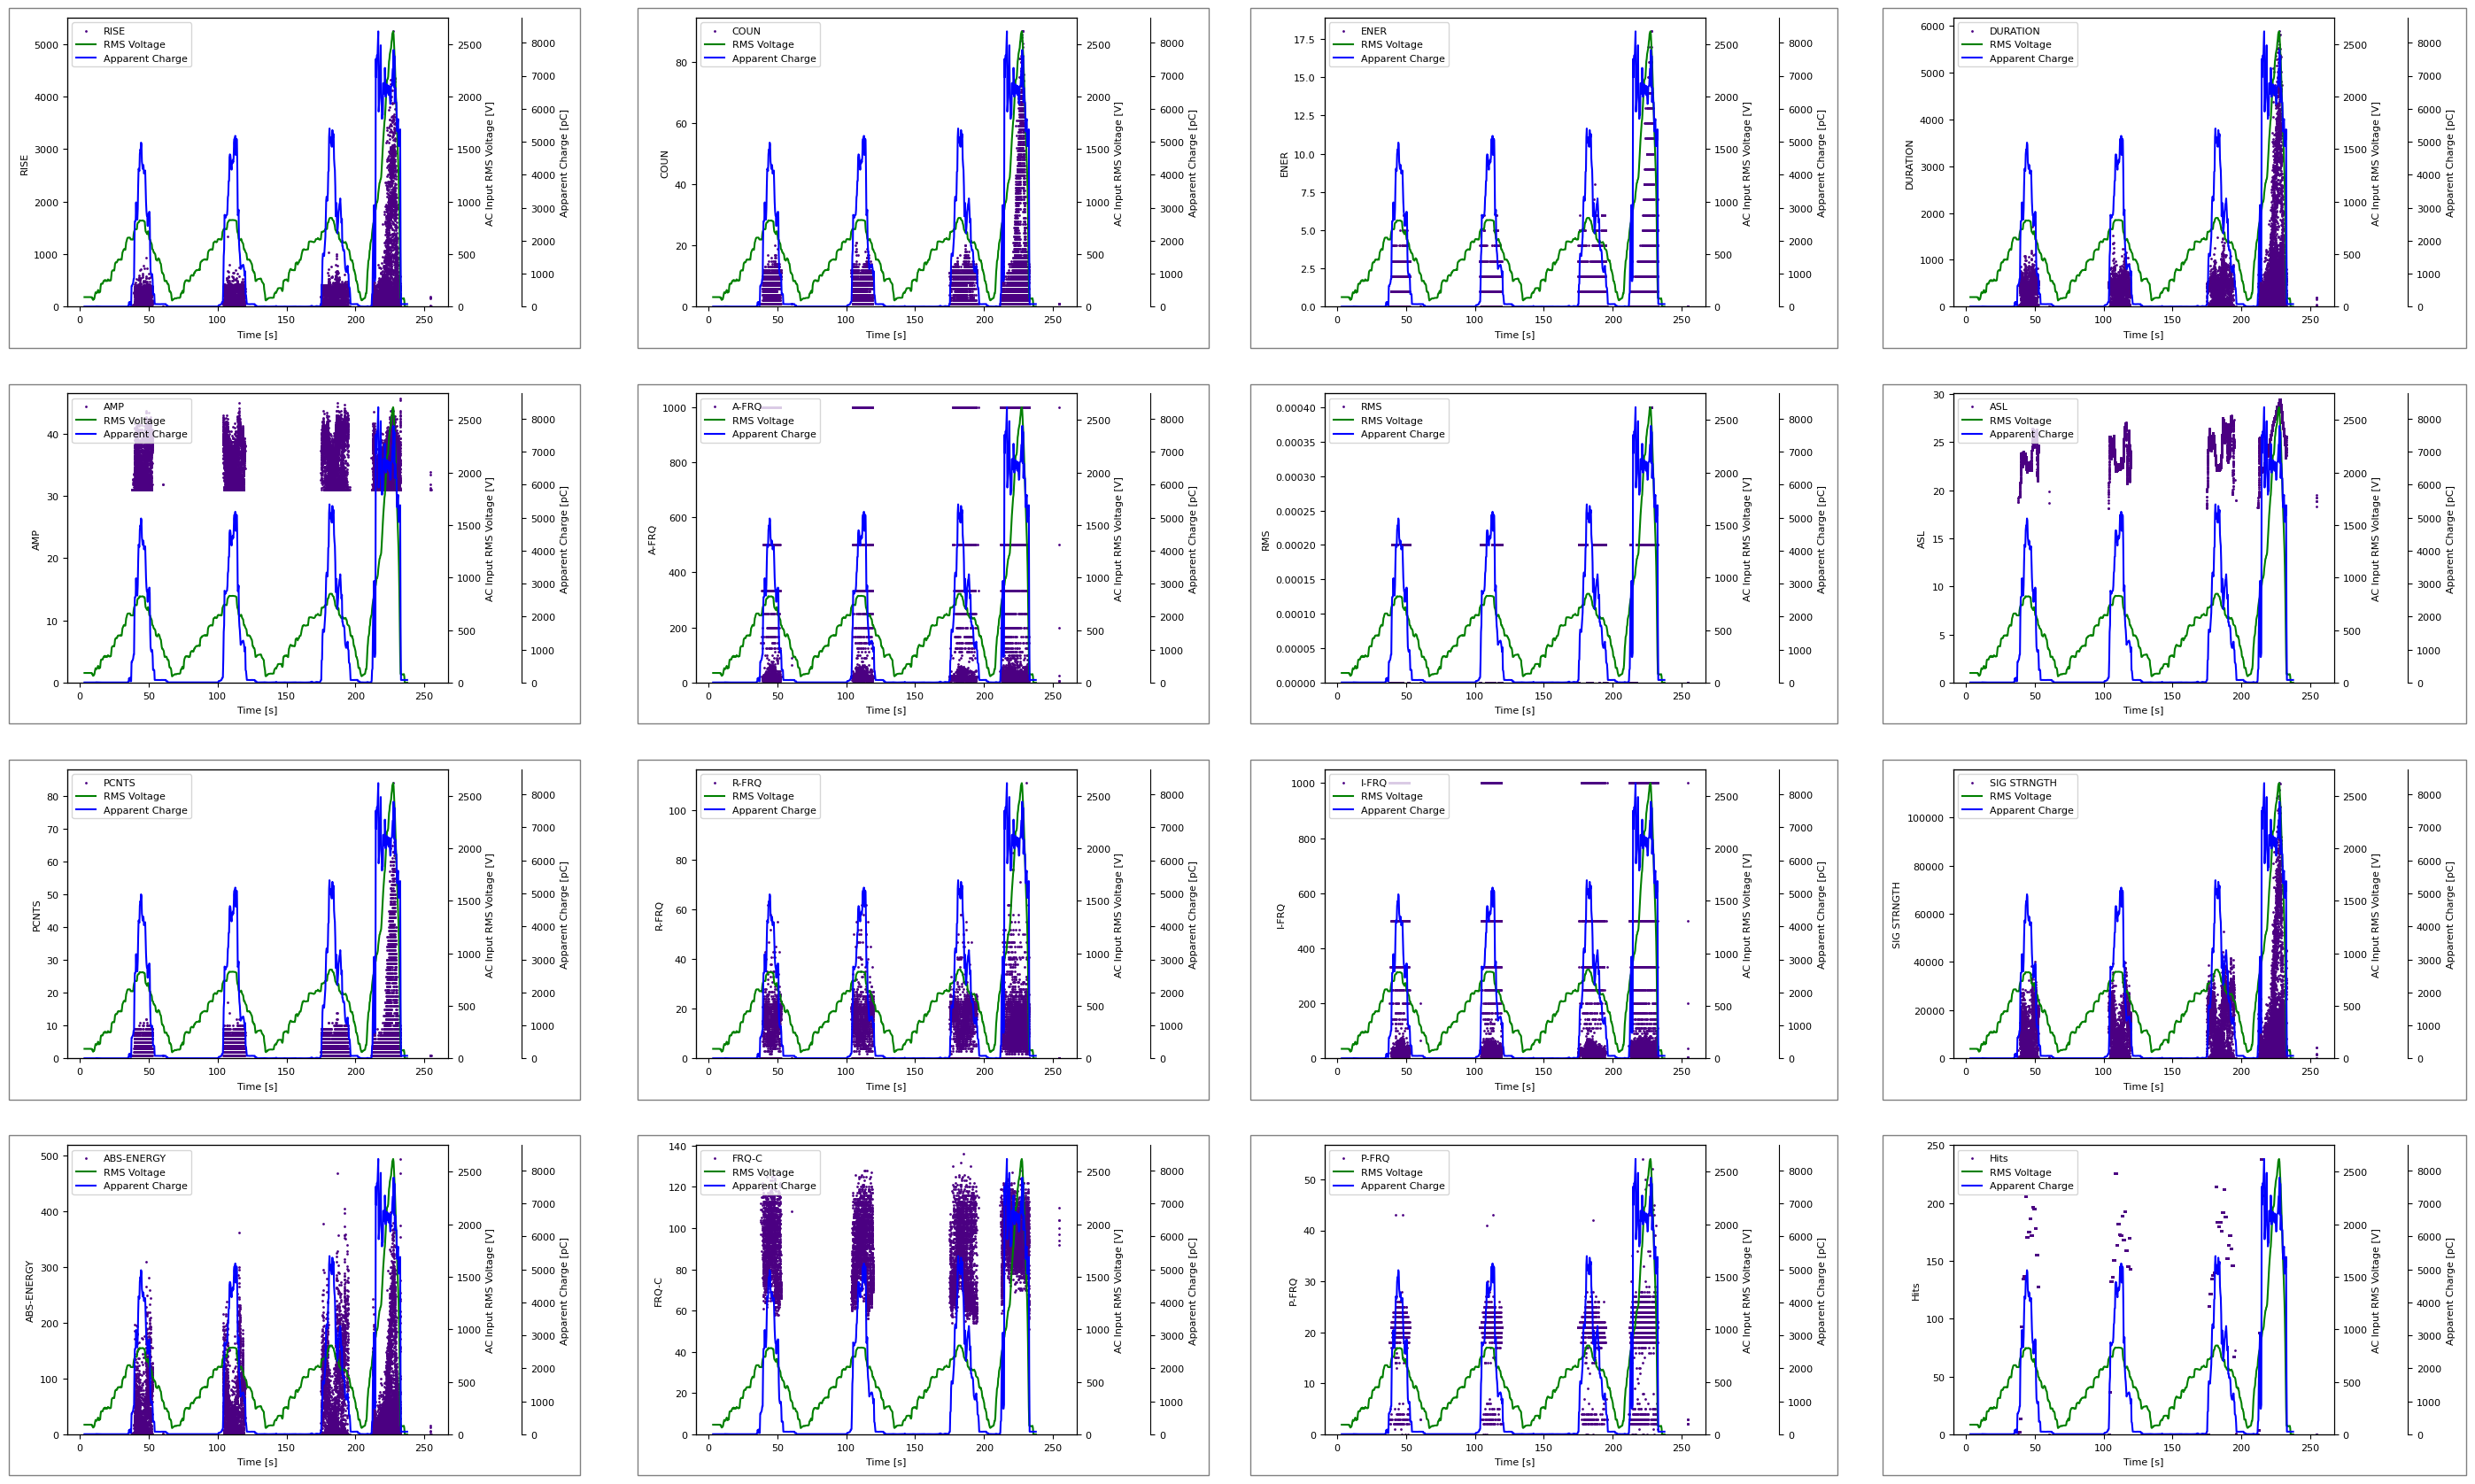

Invalid time range input. Please enter two comma-separated numbers.


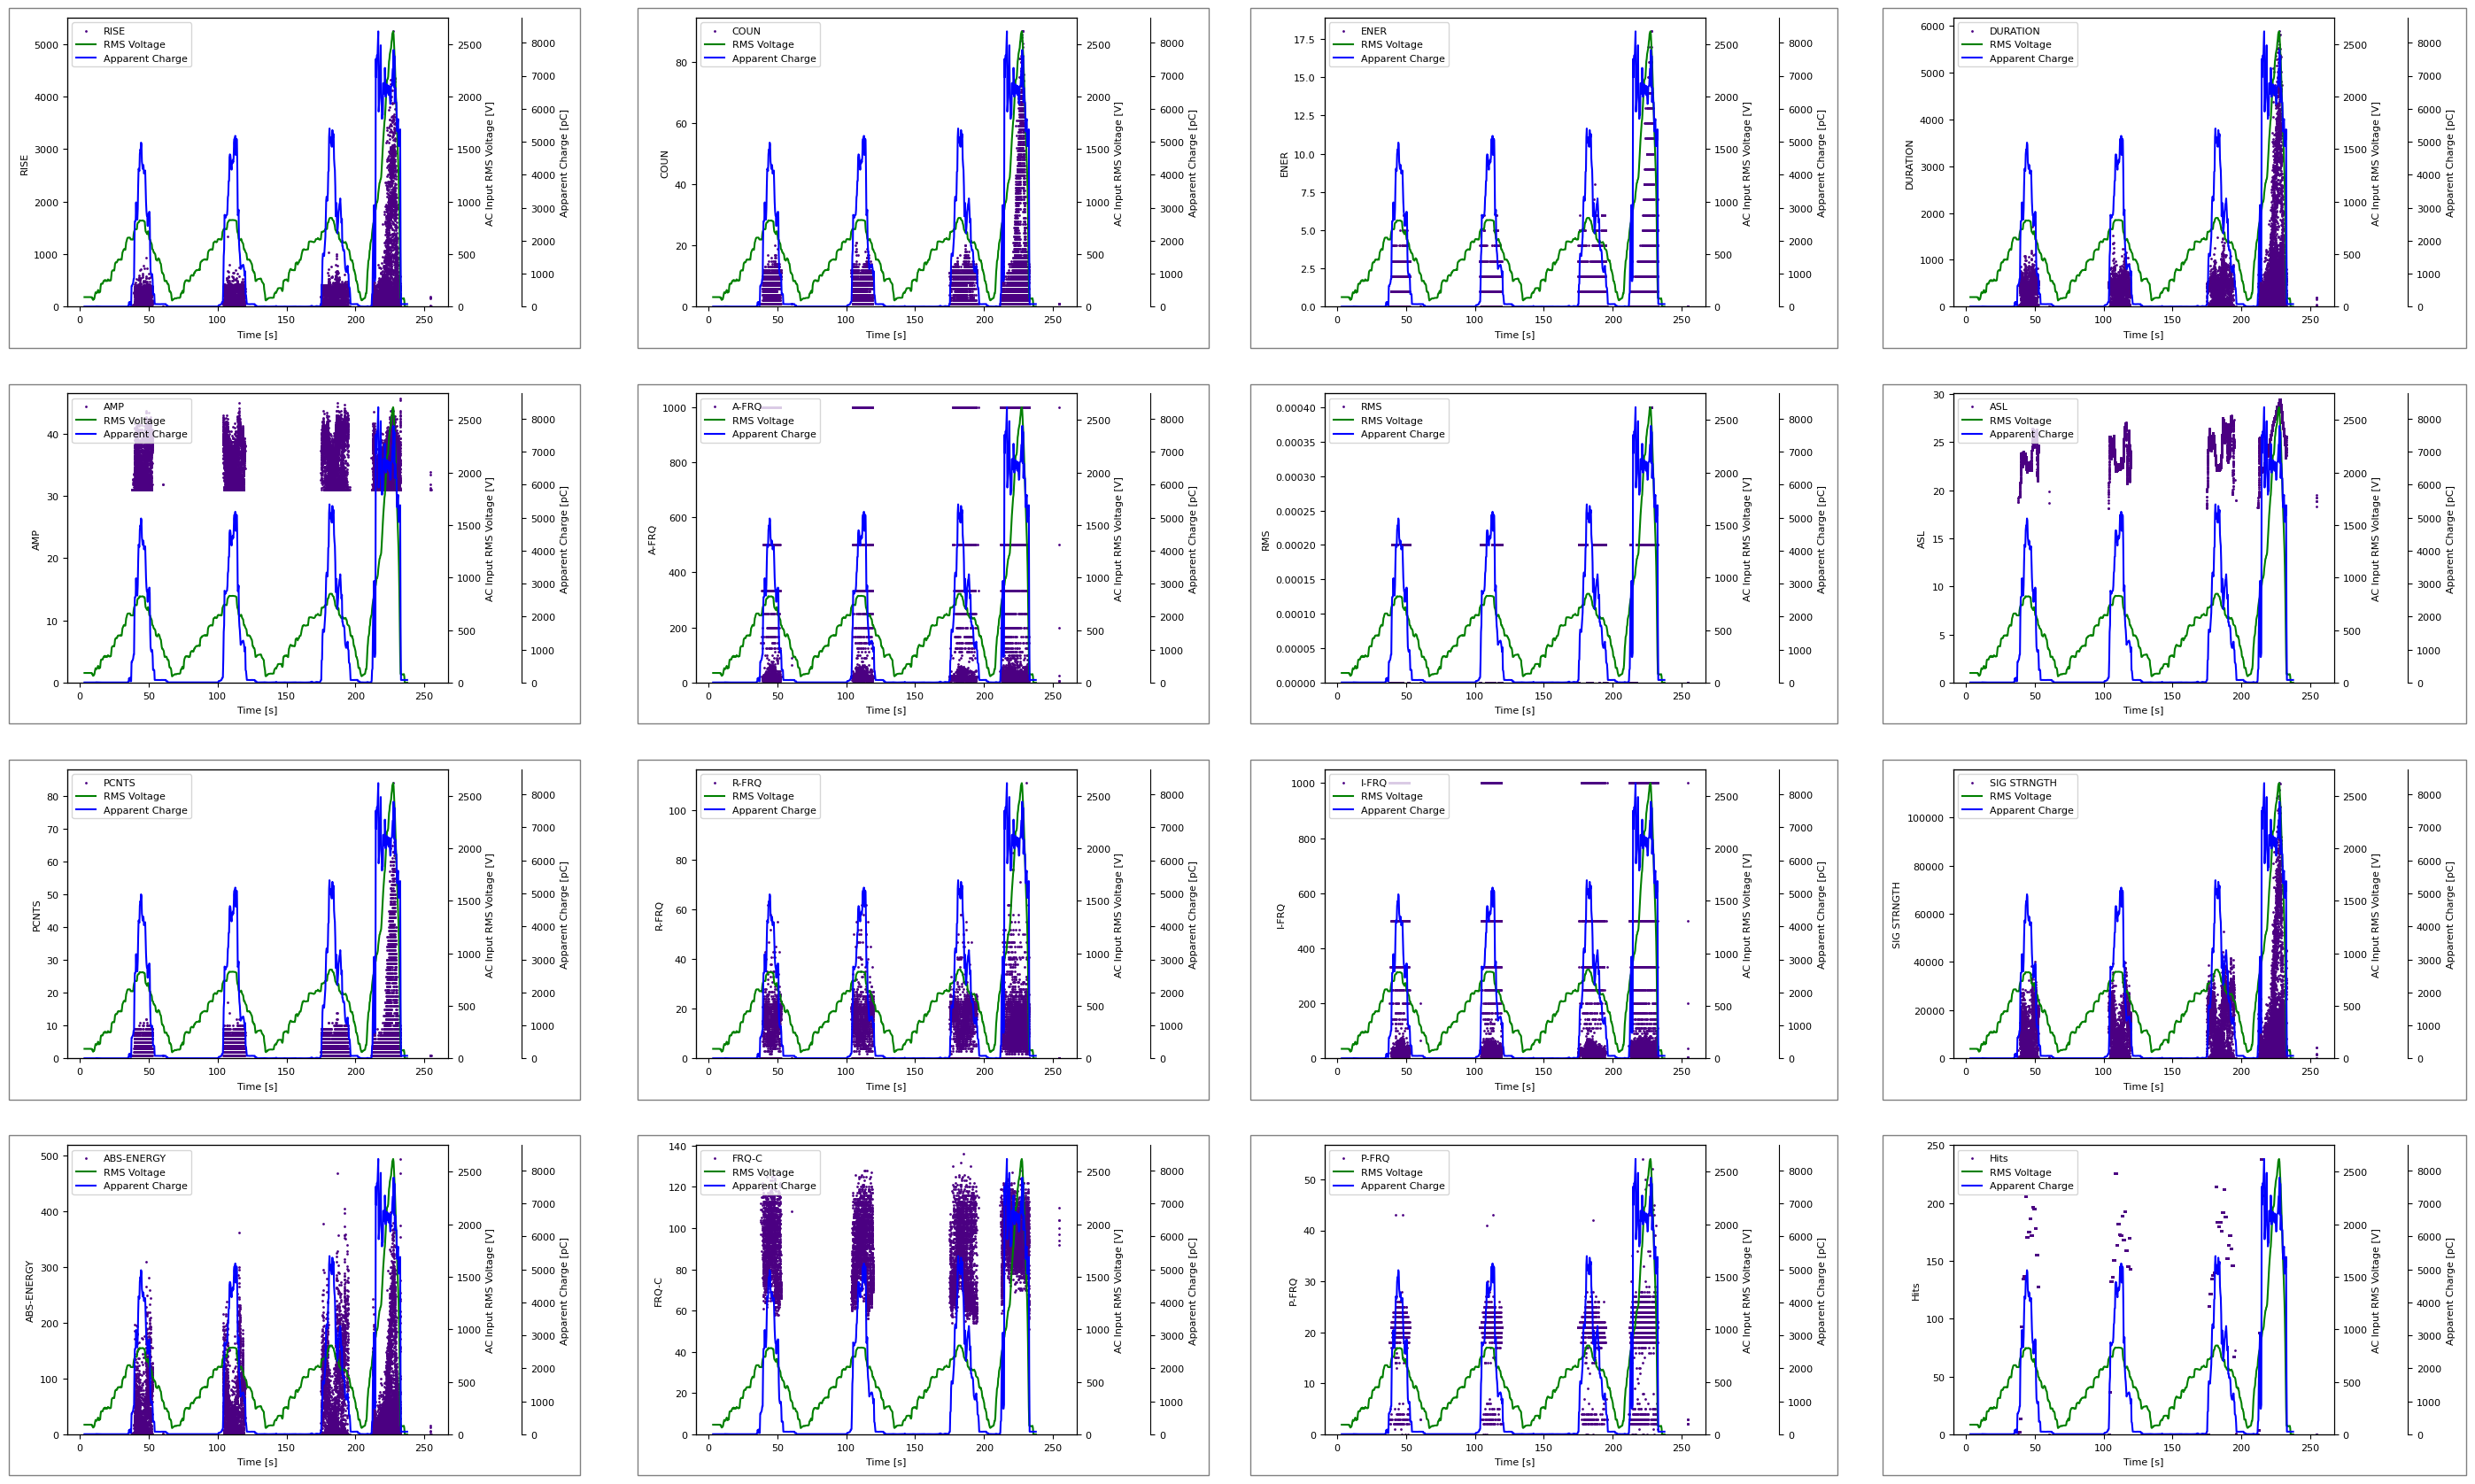

Final MPD time adjust value: -4.0


In [95]:
# TODO: Repeatedly query the user for the correct MPD_time_adjust value until they confirm that the plots are aligned

# MPD_time_adjust = -2  # Manually adjust the MPD time axis to align with the Mistras data

# # Plot all data (default behavior)
# plot_AE_features(
#     mistras_df, 
#     AE_features_to_plot, 
#     # time_range=(0, 40),
#     MPD_time_adjust=MPD_time_adjust,
# )

time_range = None         # Initially plot all data
MPD_time_adjust = 0       # No adjustment initially
while True:
    fig = plot_AE_features(mistras_df, AE_features_to_plot, MPD_time_adjust=MPD_time_adjust, time_range=time_range, columns=4)
    tr_input = input("Enter new time range as start,end (or press Enter to keep current), or type 'done' to accept current settings: ").strip()
    if tr_input.lower() == 'done':
        plt.close(fig)
        break
    elif tr_input:
        try:
            parts = tr_input.split(',')
            if len(parts) == 2:
                start_time = float(parts[0].strip())
                end_time = float(parts[1].strip())
                time_range = (start_time, end_time)
            else:
                print("Invalid time range input. Please enter two comma-separated numbers.")
                continue
        except Exception as e:
            print("Error parsing time range:", e)
            continue
    adjust_input = input("Enter new MPD time adjust value (in seconds) (or press Enter to keep current): ").strip()
    if adjust_input:
        try:
            MPD_time_adjust = float(adjust_input)
        except Exception as e:
            print("Error parsing MPD time adjust:", e)
            continue
    clear_output(wait=False)

print("Final MPD time adjust value:", MPD_time_adjust)

### Define Partial Discharge Dectection Functions

In [104]:
def get_PD_inception_times_acoustic(mistras_df, n_hits: int = 5, inception_window=1, extinction_window=1):
    """
    Get PD inception times based on acoustic data.
    
    Parameters:
        mistras_df (pd.DataFrame): DataFrame containing the AE data
        n_hits (int): Minimum number of hits to consider a PD inception in inception_window.
        inception_window (float): Time window in seconds to check for hits.
        extinction_window (float): Time window in seconds to check for no hits before the inception.
        
    Returns:
        list: List of PD inception times.
    """
    
    detected_pd_inception_times = []
    
    times = mistras_df["TIME"].to_numpy()
    
    # 2. For each time t, count hits in (t - window, t] and (t, t + window]
    for t in times:
        # masks for the two windows
        prev_mask = (times > (t - extinction_window)) & (times < t)  
        next_mask = (times > t) & (times <= (t + inception_window))
        
        # count how many hits occurred in the extinction_window before and inception_window after t
        prev_count = prev_mask.sum()
        next_count = next_mask.sum()

        # 3. PD inception if 0 before and ≥n_hits after
        if prev_count == 0 and next_count >= n_hits:
            detected_pd_inception_times.append(t)
    
    return detected_pd_inception_times

def get_PD_inception_times_electrical(MPD_df, MPD_time_adjust, n_hits: int = 5, inception_window=1, extinction_window=1, apparent_charge_threshold_pC=10):
    """
    Get PD inception times based on electrical data.
    
    Parameters:
        MPD_df (pd.DataFrame): DataFrame containing the electrical data
        n_hits (int): Minimum number of hits to consider a PD inception in inception_window.
        inception_window (float): Time window in seconds to check for hits.
        extinction_window (float): Time window in seconds to check for no hits before the inception.
        apparent_charge_threshold_pC (float): Minimum apparent charge in pC to consider a hit.
        
    Returns:
        list: List of PD inception times.
    """
    
    detected_pd_inception_times = []

    # mask out data points with apparent charge below the threshold
    MPD_df = MPD_df[MPD_df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'] >= apparent_charge_threshold_pC]  # Convert pC to C for comparison
    
    times = MPD_df["Time [s]"].to_numpy()
    
    # 2. For each time t, count hits in (t - window, t] and (t, t + window]
    for t in times:
        # masks for the two windows
        prev_mask = (times > (t - extinction_window)) & (times < t)  
        next_mask = (times > t) & (times <= (t + inception_window))
        
        # count how many hits occurred in the extinction_window before and inception_window after t
        prev_count = prev_mask.sum()
        next_count = next_mask.sum()

        # 3. PD inception if 0 before and ≥n_hits after
        if prev_count == 0 and next_count >= n_hits:
            detected_pd_inception_times.append(t)

    detected_pd_inception_times = [t + MPD_time_adjust for t in detected_pd_inception_times]  # Adjust times by MPD_time_adjust
    
    return detected_pd_inception_times

def get_voltage_electrical(MPD_df, MPD_time_adjust, time):
    """
    Get voltage based on electrical data.
    
    Parameters:
        MPD_df (pd.DataFrame): DataFrame containing the electrical data
        time (float): Time at which to get the voltage.
        
    Returns:
        float: voltage value at the specified time.
    """
    
    # Find the row corresponding to the specified time
    row = MPD_df[MPD_df['Time [s]'] == time - MPD_time_adjust]
    
    if not row.empty:
        return row['AC Input RMS Voltage [V]'].values[0]
    else:
        raise ValueError(f"No data found for time {time}.")
    
def get_voltage_ae(MPD_df, MPD_time_adjust, time):
    """
    Get voltage based on AE data.
    
    Parameters:
        MPD_df (pd.DataFrame): DataFrame containing the electrical data
        MPD_time_adjust (float): Time adjustment for the MPD data.
        time (float): Time at which to get the voltage.
        
    Returns:
        float: voltage value at the specified time.
    """

    MPD_times = MPD_df['Time [s]'].values + MPD_time_adjust  # Adjust the MPD time axis to match the Mistras df
    MPD_voltages = MPD_df['AC Input RMS Voltage [V]'].values
    
    # Find the row corresponding to the specified time
    voltage = np.interp(time, MPD_times, MPD_voltages)
    return voltage

In [106]:
ae_times = get_PD_inception_times_acoustic(mistras_df, n_hits=5)
print("PD inception times (in mistras seconds):", ae_times)

elec_times = get_PD_inception_times_electrical(MPD_df, MPD_time_adjust=MPD_time_adjust, n_hits=5, inception_window=2, apparent_charge_threshold_pC=10)
print("PD inception times (in mistras seconds):", elec_times)

print()

ae_voltages = [
    get_voltage_ae(MPD_df, MPD_time_adjust, t)
    for t in ae_times
]
elec_voltages = [
    get_voltage_electrical(MPD_df, MPD_time_adjust, t)
    for t in elec_times
]

# Pad the shorter list with NaNs so they’re the same length:
max_len = max(len(ae_times), len(elec_times))
ae_times     += [np.nan] * (max_len - len(ae_times))
ae_voltages  += [np.nan] * (max_len - len(ae_voltages))
elec_times   += [np.nan] * (max_len - len(elec_times))
elec_voltages+= [np.nan] * (max_len - len(elec_voltages))

# Build a MultiIndex for the columns:
arrays = [
    ["ae",        "ae",         "electrical",  "electrical"],
    ["time [s]",  "voltage [V]", "time [s]",   "voltage [V]"]
]
tuples = list(zip(*arrays))
cols = pd.MultiIndex.from_tuples(tuples, names=["type", "metric"])

# Assemble the DataFrame:
df = pd.DataFrame(
    list(zip(ae_times, ae_voltages, elec_times, elec_voltages)),
    columns=cols
)
df.index.name = "inception_index"

print(df)

PD inception times (in mistras seconds): [37.7220685, 103.6817295, 175.0052855, 211.2346095, 254.6881425]
PD inception times (in mistras seconds): [35.1, 100.8, 171.29999999999998, 211.8]

type                     ae             electrical            
metric             time [s] voltage [V]   time [s] voltage [V]
inception_index                                               
0                 37.722068  639.962108       35.1  657.899560
1                103.681730  716.921303      100.8  644.749423
2                175.005286  656.864188      171.3  643.366097
3                211.234610  623.212793      211.8  641.422908
4                254.688142    0.067963        NaN         NaN


Closest mistras_df TIME: 37.7220685
Interpolated AE PDIV Value: 639.9621084827467
Corresponding Time in MPD csv: 34.7220685
Interpolated endpoints: lower = 640.4040560552237 (at time 37.5) and upper = 639.8070138284194 (at time 37.8)
Maximum voltage within +/- 1.0 seconds of 37.7220685: 645.8650248387662
Minimum voltage within +/- 1.0 seconds of 37.7220685: 638.6875865684334
Electrical PDIV value: 657.8995600188142
Corresponding Time in MPD csv: 32.1


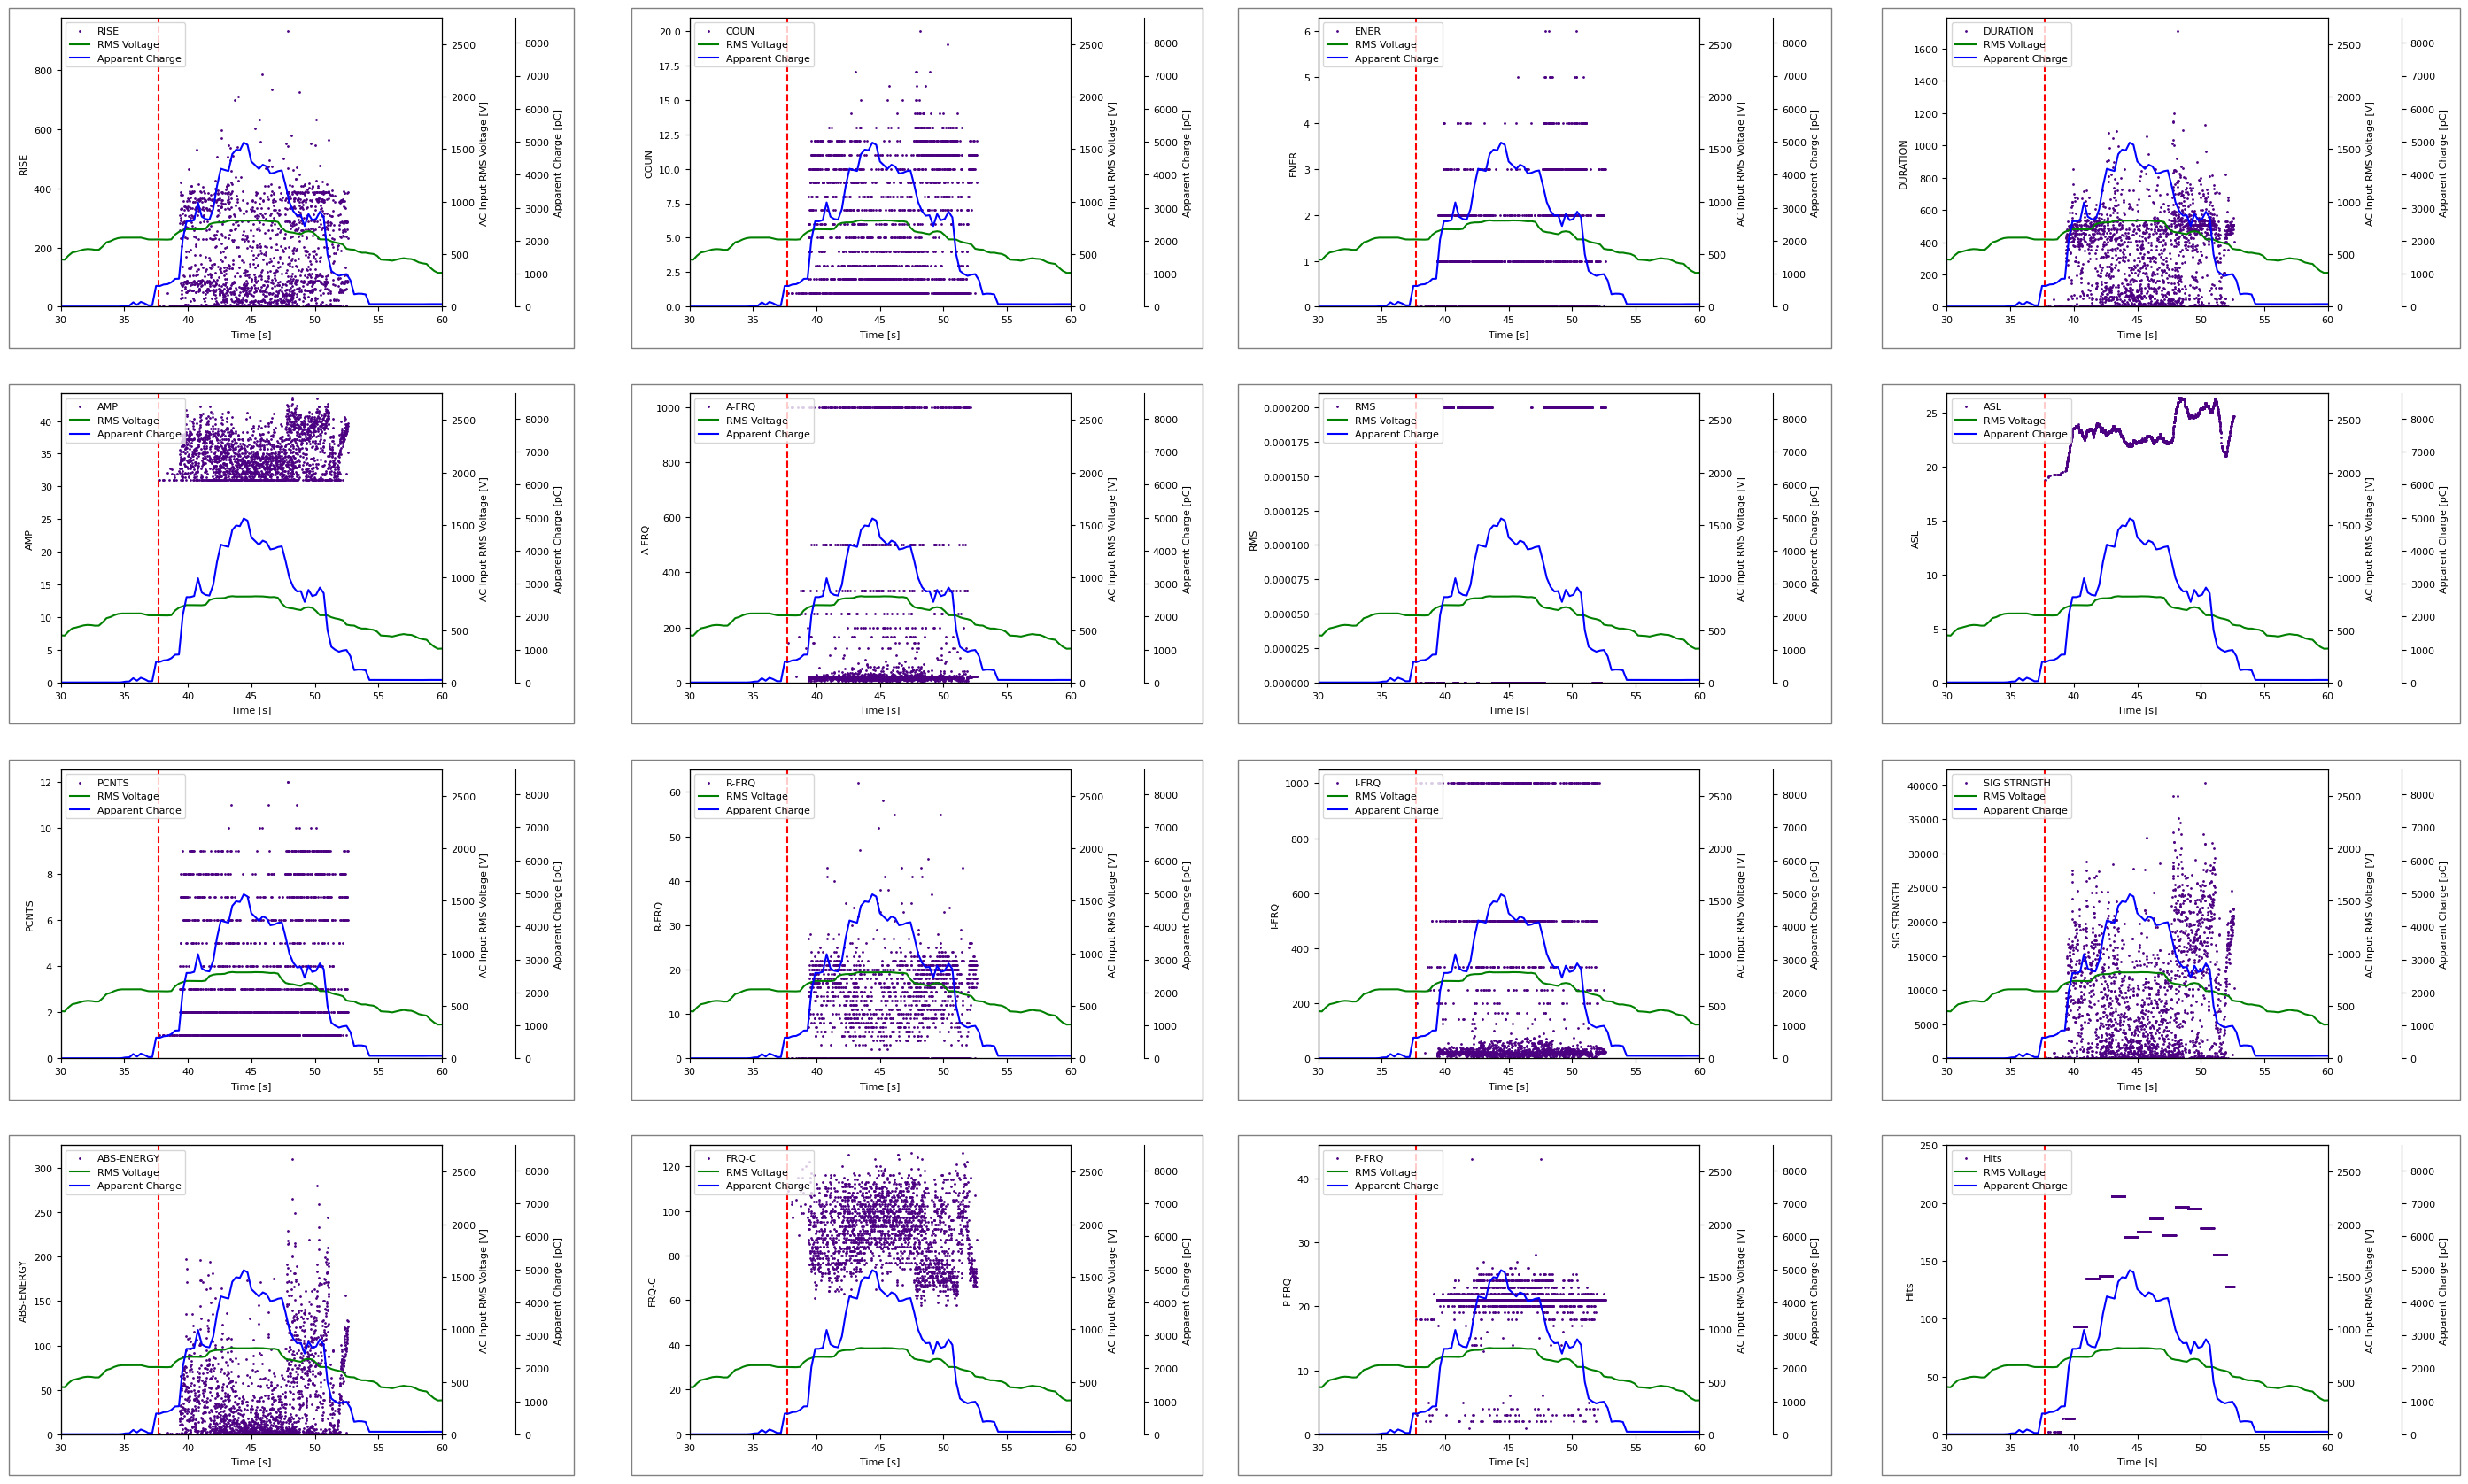

In [ ]:
# Query the user for a time value in seconds
user_input = input("Enter relative time (in seconds) after which to consider first AE hit the inception point of PDIV: ")
try:
    user_time = float(user_input)
except ValueError:
    print("Invalid input. Please enter a numerical value.")
    user_time = None

expected_user_error = 1.0  # Expected error in user-adjusted MPD-Mistras file clock offset (in seconds)

if user_time is not None:
    # Filter the DataFrame for times after or equal to user_time
    after_df = mistras_df[mistras_df['TIME'] >= user_time]
    
    if not after_df.empty:
        # Return the index of the first row in the filtered DataFrame
        closest_idx = after_df.index[0]
        # print("Closest mistras_df index after user_time:", closest_idx)
        closest_time = mistras_df.loc[closest_idx, 'TIME']
        print("Closest mistras_df TIME:", closest_time)
    else:
        raise ValueError("No data points found after the user-specified time.")

    MPD_times = MPD_df['Time [s]'].values + MPD_time_adjust  # Adjust the MPD time axis to match the Mistras df
    MPD_voltages = MPD_df['AC Input RMS Voltage [V]'].values

    # Calculate PDIV using linear interpolation at 'closest_time'
    PDIV = np.interp(closest_time, MPD_times, MPD_voltages)
    print("Interpolated AE PDIV Value:", PDIV)
    print("Corresponding Time in MPD csv:", closest_time - MPD_time_adjust + mistras_MPD_time_diff)

    # Find the indices for the two endpoints used in the interpolation
    idx = np.searchsorted(MPD_times, closest_time)

    if idx == 0:
        # closest_time is before the first data point: both endpoints are the first point.
        lower_voltage = MPD_voltages[0]
        upper_voltage = MPD_voltages[0]
        warnings.warn("closest_time is before the first time point in MPD_df.")
        print("Interpolated endpoints: lower = {} (at time {}) and upper = {} (at time {})"
            .format(lower_voltage, MPD_times[0], upper_voltage, MPD_times[0]))
    elif idx >= len(MPD_times):
        # closest_time is after the last data point: both endpoints are the last point.
        lower_voltage = MPD_voltages[-1]
        upper_voltage = MPD_voltages[-1]
        warnings.warn("closest_time is after the last time point in MPD_df.")
        print("Interpolated endpoints: lower = {} (at time {}) and upper = {} (at time {})"
            .format(lower_voltage, MPD_times[-1], upper_voltage, MPD_times[-1]))
    else:
        # closest_time is between two data points.
        lower_voltage = MPD_voltages[idx - 1]
        upper_voltage = MPD_voltages[idx]
        print("Interpolated endpoints: lower = {} (at time {}) and upper = {} (at time {})"
            .format(lower_voltage, MPD_times[idx - 1], upper_voltage, MPD_times[idx]))
        
    # Get all voltages whose times fall within the window
    time_window_mask = (MPD_times >= (closest_time - expected_user_error)) & (MPD_times <= (closest_time + expected_user_error))
    voltages_in_window = MPD_voltages[time_window_mask]

    # Compute interpolated values exactly at closest_time - expected_user_error and closest_time + expected_user_error
    interp_value_minus = np.interp(closest_time - expected_user_error, MPD_times, MPD_voltages)
    interp_value_plus = np.interp(closest_time + expected_user_error, MPD_times, MPD_voltages)

    # Append the interpolated values to the voltage set (even if they already exist in voltages_in_window)
    combined_voltages = np.concatenate(([interp_value_minus], voltages_in_window, [interp_value_plus]))
    # print("Combined Voltages: ", combined_voltages)

    if combined_voltages.size > 0:
        max_voltage = combined_voltages.max()
        min_voltage = combined_voltages.min()
        print("Maximum voltage within +/- {} seconds of {}: {}".format(expected_user_error, closest_time, max_voltage))
        print("Minimum voltage within +/- {} seconds of {}: {}".format(expected_user_error, closest_time, min_voltage))
    else:
        print("No MPD voltage values found within +/- {} seconds of {}.".format(expected_user_error, closest_time))

    # Calculate the electrical PDIV value by finding the first instance where
    # 'IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]' exceeds 10.0 and then
    # getting the corresponding 'AC Input RMS Voltage [V]' value.
    electrical_condition = MPD_df["IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]"] > 10.0
    if electrical_condition.any():
        first_electrical_idx = MPD_df[electrical_condition].index[0]
        electrical_PDIV = MPD_df.loc[first_electrical_idx, 'AC Input RMS Voltage [V]']
        print("Electrical PDIV value:", electrical_PDIV)
        print("Corresponding Time in MPD csv:", MPD_df.loc[first_electrical_idx, 'Time [s]'] + mistras_MPD_time_diff)
    else:
        print("No electrical PDIV value found, as no data point surpasses 10.0.")
    
    # Call the adapted plotting function with the computed vertical line time
    plot_AE_features(mistras_df, 
                     AE_features_to_plot, 
                     MPD_time_adjust=MPD_time_adjust, 
                     time_range=time_range,
                     vertical_line_time=closest_time,
                     columns=4)

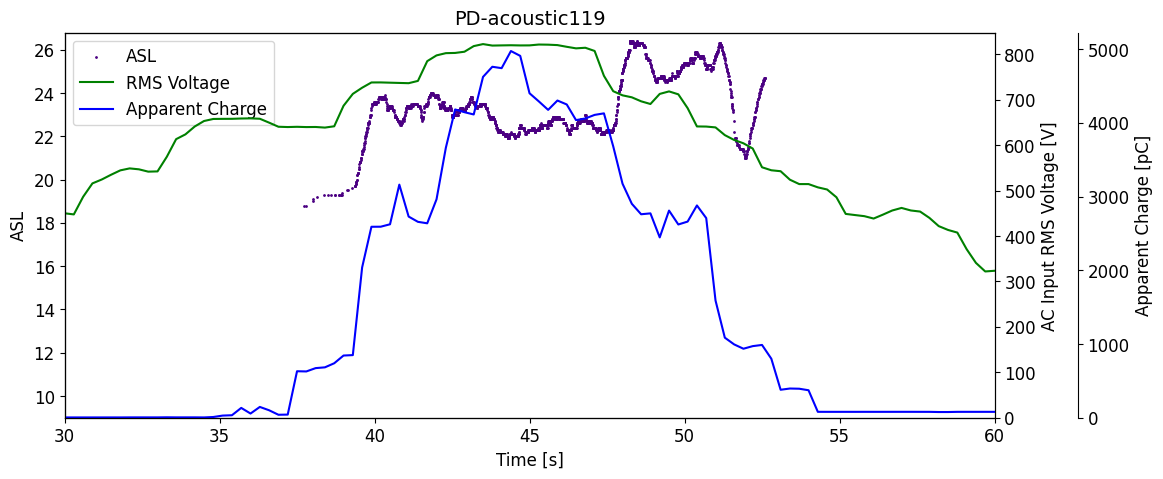

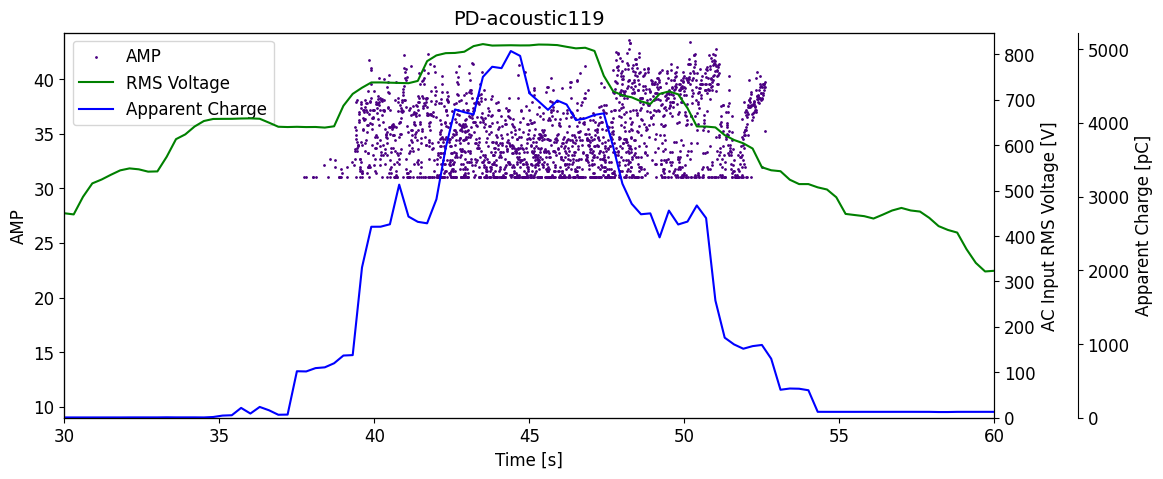

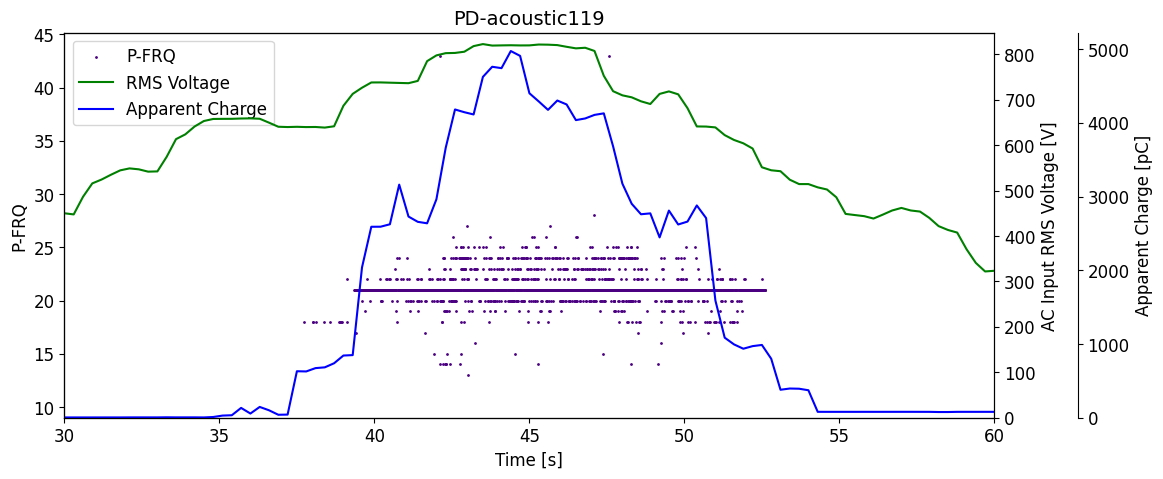

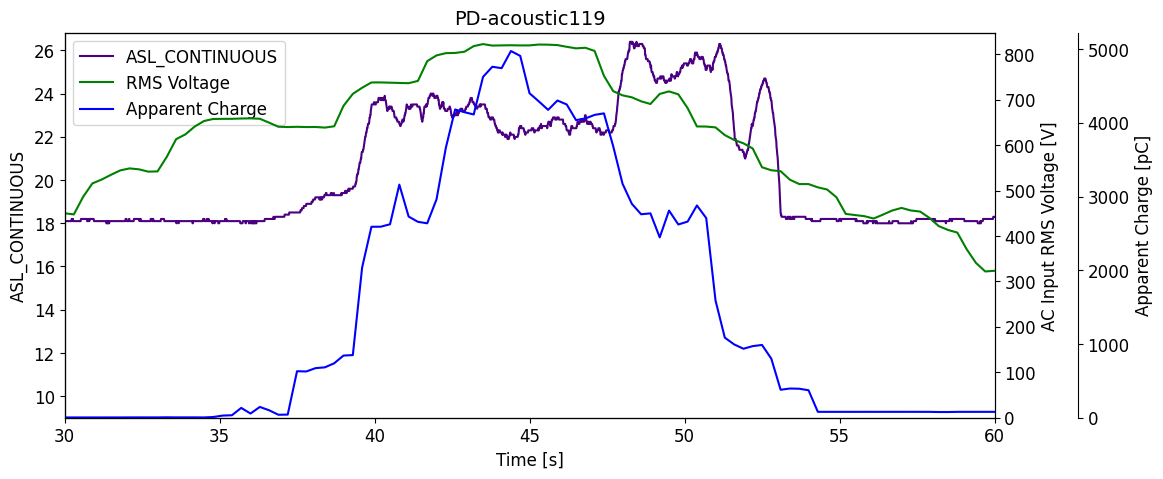

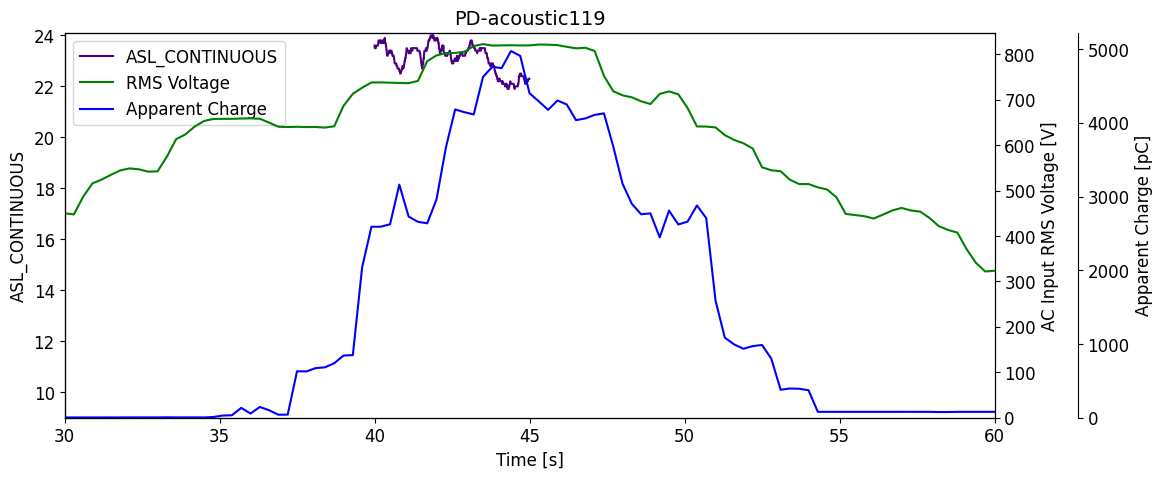

In [17]:
folder_name = os.path.basename(os.path.dirname(Mistras_filepath))

plot_single_AE_feature(
    mistras_df, 
    {'name': 'ASL', 'plot_type': 'scatter'}, 
    MPD_time_adjust=MPD_time_adjust, 
    time_range=time_range, 
    width=12, 
    height=5, 
    title=folder_name,
    ae_ymin=9
    # vertical_line_time=13.85,
    # time_error=expected_user_error
)

plot_single_AE_feature(
    mistras_df, 
    {'name': 'AMP', 'plot_type': 'scatter'}, 
    MPD_time_adjust=MPD_time_adjust, 
    time_range=time_range, 
    width=12, 
    height=5, 
    title=folder_name,
    ae_ymin=9
    # vertical_line_time=13.85,
    # time_error=expected_user_error
)

plot_single_AE_feature(
    mistras_df, 
    {'name': 'P-FRQ', 'plot_type': 'scatter'}, 
    MPD_time_adjust=MPD_time_adjust, 
    time_range=time_range, 
    width=12, 
    height=5, 
    title=folder_name,
    ae_ymin=9
    # vertical_line_time=13.85,
    # time_error=expected_user_error
)

plot_single_AE_feature(
    mistras_tdd_df, 
    {'name': 'ASL_CONTINUOUS', 'plot_type': 'line'}, 
    MPD_time_adjust=MPD_time_adjust, 
    time_range=time_range, 
    # time_range=(15,75),
    width=12, 
    height=5, 
    title=folder_name,
    ae_ymin=9,
    # vertical_line_time=41.884317,
    time_error=expected_user_error
)

masked_df = mistras_tdd_df[(mistras_tdd_df['TIME'] >= 40) & (mistras_tdd_df['TIME'] <= 45)]
plot_single_AE_feature(
    masked_df, 
    {'name': 'ASL_CONTINUOUS', 'plot_type': 'line'}, 
    MPD_time_adjust=MPD_time_adjust, 
    # time_range=(20,45), 
    time_range=time_range,
    width=12, 
    height=5, 
    title=folder_name,
    ae_ymin=9,
    # vertical_line_time=41.884317,
    time_error=expected_user_error
)

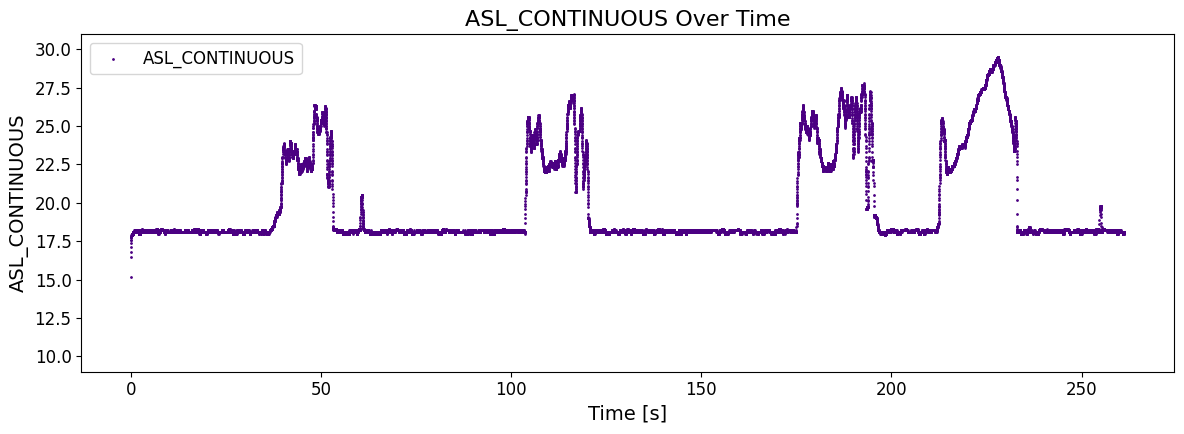

In [18]:
fig, ax1 = plt.subplots(figsize=(12,4.5))  # Increased figure size for better visibility

feature_name = 'ASL_CONTINUOUS'
# feature_name = 'ABS_ENERGY_CONTINUOUS'
# feature_name = 'ASL'

feature = ax1.scatter(mistras_tdd_df['TIME'], mistras_tdd_df[feature_name], color='indigo', label=feature_name, s=1)

# ax1.set_xlim((0,1100))
# ax1.set_ylim((0, 50))

# Increase font sizes
ax1.set_xlabel('Time [s]', fontsize=14)
ax1.set_ylabel(feature_name, fontsize=14)

# Increase tick label font size
ax1.tick_params(axis='both', which='major', labelsize=12)

# Legend and layout adjustments
lines = [feature]
labels = [feature_name]
ax1.legend(lines, labels, loc='best', fontsize=12)
ax1.set_ylim(ymin=9)

plt.title(f'{feature_name} Over Time', fontsize=16)
plt.tight_layout()
plt.show()

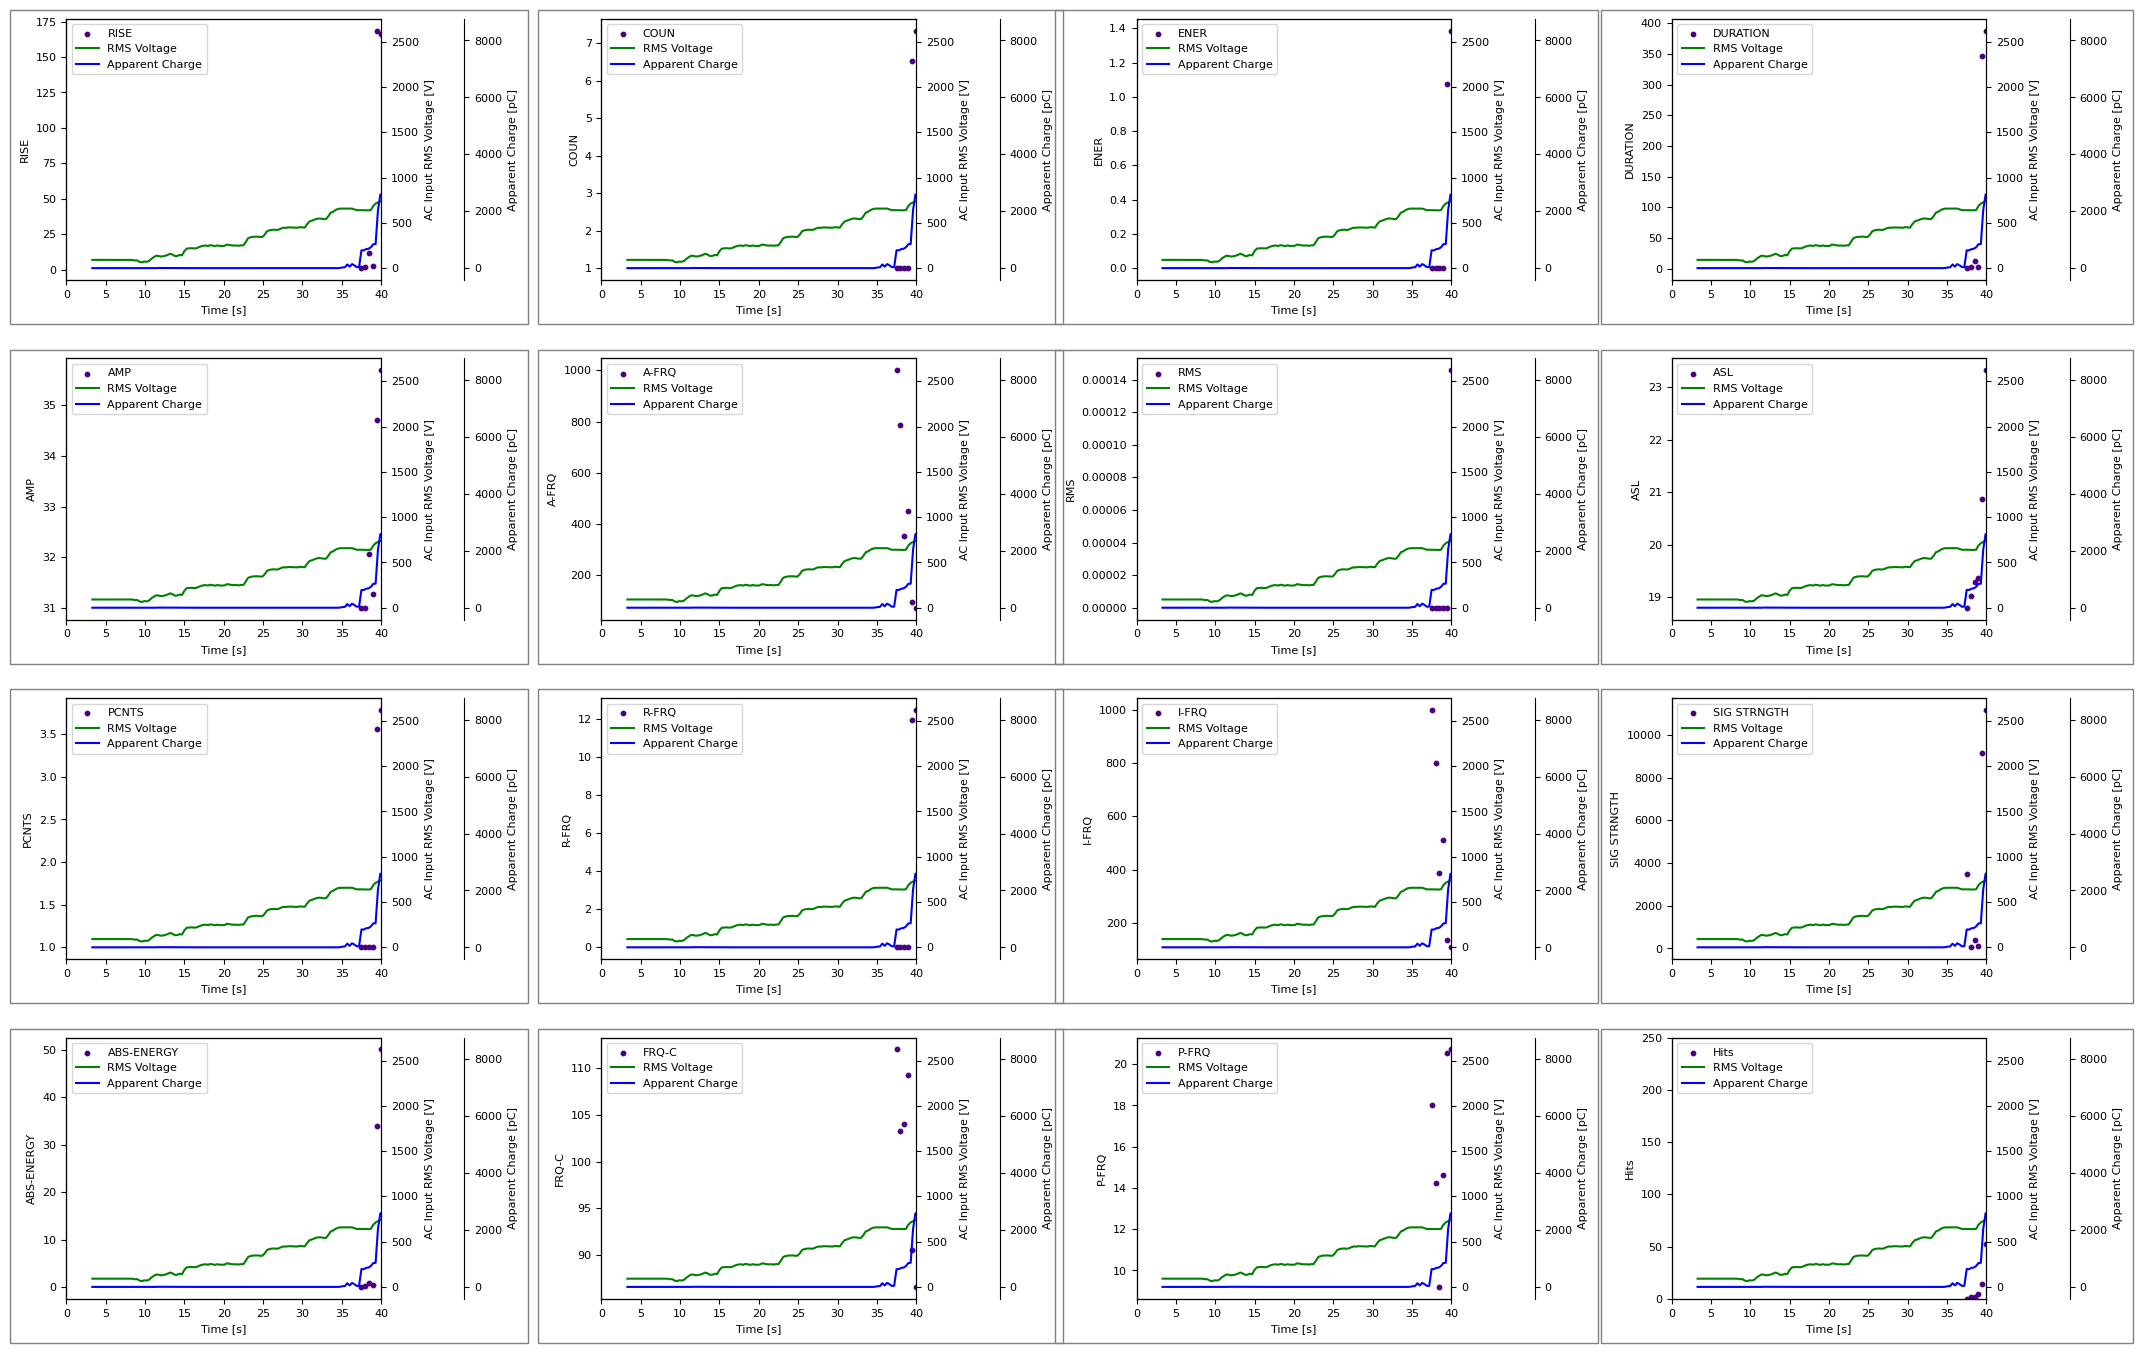

In [19]:
def plot_AE_features_averaged(mistras_df, AE_features_to_plot, trigger_delay=1.0, 
                              time_range=None, MPD_time_adjust=0, two_phase_spans=None):
    """
    Plot averaged AE features (aggregated to 0.5-second bins) with optional time range filtering
    and bordered axes groups, alongside the original MPD data.

    The high-frequency AE data (mistras_df) is averaged in half-second bins to match the MPD data sampling rate.

    Parameters:
        mistras_df (pd.DataFrame): DataFrame containing the high-frequency AE data.
                                   Must include a 'TIME' column (in seconds).
        AE_features_to_plot (list): List of dicts for features to plot. Each dict should have:
                                   - 'name': The column name (e.g. "AMP")
                                   - 'plot_type': Either "scatter" or "line"
        trigger_delay (float): Trigger delay value.
        time_range (tuple): Optional (start_time, end_time) in seconds. If None, plots all data.
        MPD_time_adjust (float): Time adjustment to be applied to the MPD data.
        two_phase_spans (list): Optional list of two-phase span tuples (each a (start, end) tuple).
    """
    # ==============================
    # 1. Aggregate AE Data into 0.5-second bins
    # ==============================
    # Create a copy to avoid modifying the original DataFrame.
    ae_df = mistras_df.copy()
    # Create a new column 'TIME_bin' by rounding 'TIME' to the nearest 0.5 seconds.
    ae_df['TIME_bin'] = (ae_df['TIME'] / 0.5).round() * 0.5
    
    # Build an aggregation dictionary for all features in AE_features_to_plot.
    agg_dict = {}
    for feature in AE_features_to_plot:
        feat_name = feature['name']
        if feat_name in ae_df.columns:
            agg_dict[feat_name] = 'mean'
    # Aggregate the data by the TIME_bin.
    ae_agg = ae_df.groupby('TIME_bin', as_index=False).agg(agg_dict)
    # Rename the time column to 'TIME' for consistency.
    ae_agg.rename(columns={'TIME_bin': 'TIME'}, inplace=True)
    
    # ==============================
    # 2. Filter Data Based on Time Range (if provided)
    # ==============================
    plot_df = ae_agg.copy()
    if time_range is not None:
        start_time, end_time = time_range
        plot_df = ae_agg[(ae_agg['TIME'] >= start_time) & (ae_agg['TIME'] <= end_time)].copy()

    # ==============================
    # 3. Set Up the Figure and Subplots
    # ==============================
    num_subplots = len(AE_features_to_plot)
    columns = 4
    rows = math.ceil(num_subplots / columns)
    mpl.rcParams['font.size'] = 8

    fig = plt.figure(figsize=(24, rows * 4))
    gs = gridspec.GridSpec(rows, columns, height_ratios=[1]*rows, width_ratios=[1]*columns)

    plt.ion()  # enable interactive mode
    axs = []
    twin_axes = []  # will store the twin axes for each subplot
    for r in range(rows):
        for c in range(columns):
            if len(axs) < num_subplots:
                axs.append(fig.add_subplot(gs[r, c]))
                twin_axes.append([None, None])

    # ==============================
    # 4. Plot the AE Features and the MPD Data
    # ==============================
    for i, ax in enumerate(axs):
        if i < num_subplots:
            # Get feature name and plot type from the input list.
            feature_to_plot = AE_features_to_plot[i]['name']
            plot_type = AE_features_to_plot[i]['plot_type']

            # Plot the aggregated AE feature.
            if plot_type == 'scatter':
                AE_plot = ax.scatter(plot_df['TIME'], plot_df[feature_to_plot],
                                     color='indigo', label=feature_to_plot, s=10)
            elif plot_type == 'line':
                AE_plot, = ax.plot(plot_df['TIME'], plot_df[feature_to_plot],
                                   color='indigo', label=feature_to_plot)

            # Create twin axes to plot the MPD data.
            ax2 = ax.twinx()
            ax3 = ax.twinx()
            twin_axes[i] = [ax2, ax3]
            
            ax2.set_ylabel("AC Input RMS Voltage [V]")
            ax3.set_ylabel("Apparent Charge [pC]")
            # Move the third y-axis slightly outward.
            ax3.spines['right'].set_position(('outward', 60))
            
            # Plot the original MPD data on the twin axes.
            MPD_voltage_plot, = ax2.plot(MPD_df['Time [s]'] + MPD_time_adjust, 
                                         MPD_df['AC Input RMS Voltage [V]'], 
                                         color='green', label='RMS Voltage')
            MPD_PD_plot, = ax3.plot(MPD_df['Time [s]'] + MPD_time_adjust, 
                                    MPD_df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'], 
                                    color='blue', label='Apparent Charge')

            # Example: if the feature is 'Hits', you might want a fixed y-range.
            if feature_to_plot == 'Hits':
                ax.set_ylim([0, 250])

            ax.set_xlabel("Time [s]")
            ax.set_ylabel(feature_to_plot)
            # Combine legends from the AE plot and the twin axes.
            lines = [AE_plot, MPD_voltage_plot, MPD_PD_plot]
            labels = [line.get_label() for line in lines]
            ax.legend(lines, labels, loc='upper left')

            # Set x-axis limits if a time range is provided.
            if time_range is not None:
                ax.set_xlim(time_range)

            # Optionally, add shaded spans (e.g., two-phase spans).
            if two_phase_spans:
                for two_phase_span in two_phase_spans:
                    ax.axvspan(two_phase_span[0] - trigger_delay, 
                               two_phase_span[1] - trigger_delay, 
                               color='red', alpha=0.2)
        else:
            # Hide any unused subplots.
            ax.set_visible(False)

    # ==============================
    # 5. Format the Figure (Borders, Spacing, etc.)
    # ==============================
    gs.update(left=0.1, right=0.9, bottom=0.1, top=0.9,
              wspace=0.7,  # Horizontal spacing
              hspace=0.3)  # Vertical spacing

    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    bbox_dims = []
    for i, ax in enumerate(axs):
        if i < num_subplots:
            bbox1 = ax.get_tightbbox(renderer)
            bbox2 = twin_axes[i][0].get_tightbbox(renderer)
            bbox3 = twin_axes[i][1].get_tightbbox(renderer)
            ylabel_bbox = ax.yaxis.label.get_window_extent(renderer)
            xlabel_bbox = ax.xaxis.label.get_window_extent(renderer)

            title_bbox = None
            if ax.get_title():
                title_bbox = ax.title.get_window_extent(renderer)
                bbox1 = bbox1.union([title_bbox])

            bbox = bbox1.union([bbox2, bbox3, ylabel_bbox, xlabel_bbox])
            bbox_fig = bbox.transformed(fig.transFigure.inverted())
            bbox_dims.append((i, bbox_fig.bounds))

    col_widths = [0] * columns
    col_lefts = [float('inf')] * columns
    row_heights = [0] * rows

    for i, (x0, y0, width, height) in bbox_dims:
        col = i % columns
        row = i // columns
        col_widths[col] = max(col_widths[col], width)
        col_lefts[col] = min(col_lefts[col], x0)
        row_heights[row] = max(row_heights[row], height)

    for i, (orig_x0, orig_y0, _, _) in bbox_dims:
        if i < num_subplots:
            col = i % columns
            row = i // columns

            x0 = col_lefts[col]
            width = col_widths[col]
            height = row_heights[row]

            xpad = 0.02 * width
            ypad = 0.03 * height

            rect = plt.Rectangle((x0 - xpad, orig_y0 - ypad),
                                 width + 2 * xpad, height + 2 * ypad,
                                 edgecolor='gray', linewidth=1, fill=False,
                                 transform=fig.transFigure)
            fig.add_artist(rect)

    plt.show()

plot_AE_features_averaged(mistras_df, AE_features_to_plot, trigger_delay=1.0, 
                              time_range=(0, 40), MPD_time_adjust=MPD_time_adjust, two_phase_spans=None)

In [20]:
# -----------------------------
# 1. Adjust the MPD Data Time
# -----------------------------
# Assume MPD_df contains a 'Time [s]' column.
# Adjust the MPD time using the same offset as in your plotting code.
# MPD_time_adjust = -2
MPD_df = MPD_df.copy()  # if you want to preserve the original DataFrame
mpd_sample_period = MPD_df['Time [s]'].iloc[1] - MPD_df['Time [s]'].iloc[0]
MPD_df['TIME'] = MPD_df['Time [s]'] + MPD_time_adjust

# -----------------------------
# 2. Aggregate the AE (Mistras) Data
# -----------------------------
# Create a new column that rounds the AE time to the nearest sample time in the MPD file
# (This will bin the data so that each MPD sample gets the average of the nearby AE values.)
mistras_df = mistras_df.copy()  # if you want to avoid modifying the original DataFrame
mistras_df['TIME_bin'] = (mistras_df['TIME'] / mpd_sample_period).round() * mpd_sample_period

# Group the mistras_df data by these bins and compute the mean of 'AMP'
# (If you need to aggregate other AE features, add them to the aggregation dictionary.)
mistras_agg = (mistras_df
               .groupby('TIME_bin', as_index=False)
               .agg({'AMP': 'mean'}))
               
# -----------------------------
# 3. Merge Aggregated AE Data with MPD Data
# -----------------------------
# If the MPD times exactly align with the half-second bins,
# you can merge directly on the 'TIME' column.
merged_df = pd.merge(MPD_df, mistras_agg, left_on='TIME', right_on='TIME_bin', how='inner')

# ---
# Alternatively, if MPD_df['TIME'] is not exactly on the half-second bins,
# you can use merge_asof to join based on the nearest half-second.
# (Uncomment the following code block if needed.)
# 
# mistras_agg = mistras_agg.sort_values('TIME_bin')
# MPD_df = MPD_df.sort_values('TIME')
# merged_df = pd.merge_asof(MPD_df, 
#                           mistras_agg, 
#                           left_on='TIME', 
#                           right_on='TIME_bin', 
#                           direction='nearest', 
#                           tolerance=0.25)
# merged_df = merged_df.dropna(subset=['AMP'])
# ---

# Now, merged_df contains the MPD data along with the corresponding averaged AMP values.
# You can inspect merged_df.head() to verify the merge.

In [21]:
display(merged_df)

,Absolute Time,Time [s],IEC 60270 Apparent Charge (Q_IEC/WTD) [pC],AC Input RMS Voltage [V],AC Input Peak Voltage / Sqrt(2) [V],AC Input signal frequency [Hz],total PD Rate [Pulses/s],PD Rate relevant for Q_IEC/WTD [Pulses/s],Maximum Charge of PD events in interval [C],Quadratic Rate D (from IEC 60270) [C²/s],Average charge in interval [C],Average Q_IEC/WTD charge in interval [C],Minimum Charge of PD events in interval [C],Average discharge power in interval [W],Average discharge current in interval [A],AC Input Peak Current / Sqrt(2) [A],AC Input RMS Current [A],TIME,TIME_bin,AMP


In [22]:
# -----------------------------
# 4. Run the Multiple Linear Regression
# -----------------------------
# We want to regress the AE 'AMP' (dependent variable)
# against the dual predictors from MPD: 'AC Input RMS Voltage [V]' and
# 'IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'.

# Define the dependent variable
y = merged_df['AMP']

# Define the independent variables
X = merged_df[['AC Input RMS Voltage [V]', 'IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]']]

# Add a constant term (intercept) to the predictors
X = sm.add_constant(X)

# Fit an Ordinary Least Squares (OLS) regression model
model = sm.OLS(y, X).fit()

# Display the regression summary
print(model.summary())

ValueError: zero-size array to reduction operation maximum which has no identity